In [1]:
from gradient_descent import gradient_descent, minibatch_class
import utils
from utils import Poisson_reg
from utils import sample_PLN

import matplotlib.pyplot as plt
from pandas import read_csv
import math
from timeit import default_timer as timer
from tqdm import tqdm 
import time 
import sys 

from __future__ import print_function
import psutil
import multiprocessing
import concurrent.futures
import threading

import numpy as np
import torch
from torch import nn
import scipy.linalg as SLA 
from scipy.linalg import toeplitz 
torch.set_default_dtype(torch.float64)

In [2]:
class PLN_full():
    def __init__(self, C_init, beta_init, M_init, S_init, requires_tridiag = True): 
        '''
            Initialization : 
            'Y' : the data, size (n,p). n is the number of samples we have and p the number of species. 
                  the entries should be int but dtype = float. 
            'O': offset : additional offset. (not very important for comprehension). size (n,p)
            'covariates' : covariates, size (n,d)
            'C_init' : initialization for C. I plan to do a more advanced initialization. 
            'beta_init ' : Initialization for beta. I plan to do a more advanced initialization. 
            'M_init' : initialization for the variational parameter M
            'S_init ': initialization for the variational parameter S
            'requires_tridiag' : bool. If True, the parameters C wil be a vector 
                                of size (n(n+1)/2). It will form a lower tridiagonal matrix after,
                                but we encode it as a vector for pytorch. Advantages : we get about half less 
                                parameter if True. 
                                If False, C will be a Matrix of size (n,n). It won't be a lower tridiagonal Matrix
                                after some gradient steps. 
        '''
        # model parameters
        
        # we start with the initialization of C, that is the most subtle. If you want tridiagonals matrices 
        # at every iteration then the parameters C of the optimizer will be a vector ( we will change this vector 
        # into a matrix at each iteration to compute the loss. It is more convenient this way. 
        #Else, it will be a matrix

        
        if requires_tridiag : 
            self.C = torch.clone(mat2vec_lower_tridiag(C_init))
            self.requires_tridiag = True 
        else : 
            self.C = torch.clone(C_init) 
            self.requires_tridiag = False 
            
        self.C.requires_grad_(True)
        self.Sigma = torch.clone(torch.mm(C_init,C_init.T))
        self.Sigma.requires_grad_(False) # we don't need to have a gradient for Sigma since we will 
                                         # always update it with a closed form (since we have constraints
                                         # of positivity and symmetry)
        #note that C and sigma have a similr role here. We will use either C or Sigma 
        #depending on the loss we choose. 
        
        self.beta = torch.clone(beta_init)
        self.beta.requires_grad_(True)
        
        #variational parameters
        self.M = torch.clone(M_init)
        self.M.requires_grad_(True)
        self.S = torch.clone(S_init) 
        self.S.requires_grad_(True)
        
        
        
        self.params = {'S' : self.S,'M' : self.M,'C' : self.C, 'beta' : self.beta, 'Sigma' : self.Sigma}
        
        self.old_loss = 1
        
        # some lists to store some stats
        self.t0 = time.time()
        self.MSE_Sigma_list = list()
        self.MSE_beta_list = list()
        self.ELBO_list = list()
        self.running_times = list()

        
    def extract_data(self,data): 
        '''
        function to extract the data. This function is just here to have a code more compact. 
        
        args : 
              'data': list with 3 elements : Y, O and covariates in this order. 
        '''
        #known variables
        self.Y = data[0];self.O = data[1];self.covariates = data[2]
        self.n, self.p = self.Y.shape
        
        
        
    ###################### parametrisation centered in X@\beta, variance CC.T ##############
    
    
    
    def compute_ELBO(self): 
        '''
        compute the ELBO with the parameter of the model we have extract. 
        This ELBO uses the parametrization for Z ~ N(XB,Sigma)
        '''
        return ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_tridiag(self): 
        '''
        same function as above, but the parameter C is a vector here. 
        it does the same but changes C from a vector to a lower tridiagonal Matrix. 
        '''
        return ELBO_tridiag(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_Sigma(self): 
        '''
        Computes the ELBO when Sigma is the parameter, (in opposition to C)
        '''
        return ELBO_Sigma(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    
    
    
    
    ####################### parametrisation centered in 0, variance Sigma  ################
    
    
    
    
    
    def compute_first_ELBO(self):
        '''
        compute the ELBO of the first notebook, i.e. another parametrisation 
        '''
        return first_ELBO(self.Y,self.O , self.covariates,self.M ,self.S ,self.Sigma ,self.beta)
    def compute_profile_ELBO(self): 
        '''
        compute the ELBO from the profiled formula. 
        '''
        self.Sigma = first_closed_Sigma(self.M,self.S) # we update Sigma 
        gain = profile_ELBO(self.Y,self.O,self.covariates,self.M,self.S, self.Sigma,self.beta)
        return gain
    
    
    ##################### parametrisation centered in 0 and unit variance ##################
    
    
    
    
    def compute_ELBO_PCA(self): 
        '''
        compute the ELBO from the PCA parametrization.
        '''
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,self.C ,self.beta)
    
    def compute_ELBO_PCA_tridiag(self): 
        '''
        compute the ELBO when C is a vector that encodes a tridiagonal Matrix from the PCA parametrisation
        '''
        matC = vec2mat_lower_tridiag(self.C)
        return ELBO_PCA(self.Y,self.O , self.covariates,self.M ,self.S ,matC ,self.beta)
    
    

    
    
    # gradient ascent function, core function of the class. 
    def torch_gradient_ascent(self, optimizer, compute_gain,params, tolerance , N_epoch ,  requires_closed_Sigma, verbose): 
        '''
        gradient ascent function. We compute the gradients thanks to the autodifferentiation of pytorch. 

        args : 
                'optimizer' : torch.optim.optimizer. the optimizer for the parameters. 

                'compute_gain' : function. It should call the parameters by itself. i.e. we wil 
                                all compute_gain() without any parameter in argument. 

                       
                'tolerance': float. the threshold we set to stop the algorithm. It will 
                              stop  if we are not improving the loss more than tolerance. 
                              
                'N_epoch': int. the Maximum number of epoch we are ready to do. 
                
                'requires_closed_Sigma' : bool. tells if we are using Sigma (True) or C(False). 
                                          Here just to keep track of the error.
                                          between self.Sigma and true_Sigma

                'Verbose' : bool. if True, will print some messages useful to 
                            interpret the gradient ascent. If False, nothing will be printed. 
 
        returns : None 
        '''
        #scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.5,patience = 3)
        # we set the gradient to zero just to make sure the gradients are properly calculated
        optimizer.zero_grad()

        stop_condition = False 
        i = 0

        while i < N_epoch and stop_condition == False: 
            optimizer.zero_grad()
            loss = -compute_gain()
            loss.backward()
            #print('sanity check : ', torch.norm(params['beta'].grad+grad_beta(data[0], data[1],data[2] ,params['M'] ,params['S'] ,params['C'] ,params['beta']) ))
            if torch.isnan(loss).item() == True : 
                print('NAN')
            optimizer.step()
            
            delta = self.old_loss - loss.item() 
            '''
            if delta < 0 : 
                print('We regressed of ', delta )
            else : 
                print('We gain ', delta )
            '''
            # condition to see if we have reach the tolerance threshold
            if  abs(delta) < tolerance :
                stop_condition = True 
            
            self.old_loss = loss.item()
            
            # keep track of the error with Sigma. 
            if requires_closed_Sigma : # if we use Sigma as parameter 
                self.MSE_Sigma_list.append(torch.mean((self.Sigma-true_Sigma)**2).item())
            else : #if we use C 
                if len(params['C'].shape) > 1 : # C is a matrix ( requires_tridiag = False)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(self.C,self.C.T)-true_Sigma)**2).item())
                else : # C is a vector (requires_tridiag = true)
                    self.MSE_Sigma_list.append(torch.mean((torch.mm(vec2mat_lower_tridiag(self.C),
                                                           vec2mat_lower_tridiag(self.C).T)-true_Sigma)**2).item())

            self.MSE_beta_list.append(torch.mean((self.beta-true_beta)**2).item())
            self.ELBO_list.append(-loss.item())
            # print some stats if we want to
            if i%200 == 0 and verbose : 
                print('iteration number: ', i)
                print('-------UPDATE-------')
                print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
                print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
                print('ELBO : ', np.round(-loss.item(),5))
                print('Delta : ', delta)
            i += 1
            #keep track of the time 
            self.running_times.append(time.time()-self.t0)

        # print some stats if we want to 
        if verbose : 
            if stop_condition : 
                print('---------------------------------Tolerance {} reached in {} iterations'.format(tolerance, i))
            else : 
                print('---------------------------------Maximum number of iterations reached : ', N_epoch, 'last delta = ', delta)
 
            print(' MSE with Sigma : ', np.round(self.MSE_Sigma_list[-1],5))
            print(' MSE with beta : ', np.round(self.MSE_beta_list[-1],5))
        
    
    ### we will build all the algorithms based on the previous function. The function will 
    ### basically be the same, we will change the gain considered (depends on the parametrisation we take 
    ### mainly). We will also update the parameters if we have closed form. 
    
    
    
    
    ####### parametrisation centered in 0 and unit variance #########
    
    
    
    def full_grad_ascent_PCA(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta) with the loss from the PCA
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_PCA_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO_PCA
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
        
        
        
        
    ########## parametrisation centered in X@\beta, variance C.C.T ###########
    
    
    
    
    
    def full_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True ): 
        '''
        Gradient ascent for all the parameters (M,S,C,beta)
        
        args : 
              'data' : list containing in this order Y,O,covariates. 
              'lr' : float, beginning learning rate for the optimizer 
              'N_epoch' : int, the number of iteration required. 
              'verbose' : bool, will pint some stats if True
              
        returns : None but the parameters are optimized. 
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M,self.C, self.beta], lr = lr)
        
        # we extract the data
        self.extract_data(data)
        
        #we choose the right loss. Note that both loss uses C and not Sigma. 
        #if we have chosen a tridiagonal matrix : 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : # if we have not chosen a tridiagonal matrix,
            gain = self.compute_ELBO
        
        #gradient ascent. no tolerance, we only want to do the number of epochs required 
        #we don't want a closed form for Sigma. 
        self.torch_gradient_ascent(self.optimizer, gain,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= False,verbose = verbose)
        
    def VEM_beta_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.03, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update beta with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,C)
        for N_epoch_max iteration and then update beta.
        args : same as above. 
        '''
        
        self.optimizer = torch.optim.Adam([self.S,self.M,self.C], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        # choose the right loss. Note that the loss uses C here. 
        if self.requires_tridiag : 
            gain = self.compute_ELBO_tridiag
        else : 
            gain = self.compute_ELBO
            
        for i in range(Number_VEM_step): 
            #gradient ascent for N_epoch_max iteration maximum. 
            self.torch_gradient_ascent(self.optimizer, gain ,self.params, 
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= False, verbose = verbose)
            if verbose : 
                print(' i : ', i )
            #update beta
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
        
        
        
        
    ########## parametrisation centered in X@\beta and variance Sigma ###############
    
    
    
    def profile_grad_ascent(self,data, N_epoch = 1000, lr = 0.01,  verbose = True):
        
        '''
        gradient ascent with the profiled formula. We replace Sigma by the argmax in some part 
        to avoid computing the inverse of Sigma. 
        args : same as above     
        '''
        self.extract_data(data)
        self.optimizer = torch.optim.Adam([self.S,self.M,self.beta], lr = lr)
        # we first do one simple gradient ascent to avoid computing the log of zero. (does not work very well yet)
        self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = 0 , N_epoch = 20 ,
                requires_closed_Sigma= True, verbose = verbose)
        
        self.torch_gradient_ascent(self.optimizer, self.compute_profile_ELBO,self.params,tolerance = 0,  
                            N_epoch = N_epoch,requires_closed_Sigma= True,verbose = verbose)
    
    def VEM_both_closed(self,data,Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True ): 
        '''
        VEM where we use the closed form both of Sigma and beta. As a result, 
        the M-step is straightforward as we only choose update beta and sigma once. 
        The VE-step uses optimization.
        
        args : same as above except : 
              -'tolerance' : float. Threshold 
              that tells when to stop. If the gain have not improved 
              of more than tolerance, then we stop the VE step. 
              The tolerance of the first step will start at tolerance, 
              but will be decreased at each iteration at a factor of 1/i. 
              -'Number_VEM_step' int. The number of times we will do a VE and a M step.   
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M], lr = lr)
        self.extract_data(data)
        self.beta.requires_grad_(False) # beta won't be optimize here but set to its closed form 
        for i in range(Number_VEM_step): 
            # VE step. We choose the gain that uses Sigma and not C. 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params, 
                            tolerance = tolerance/(i+1),N_epoch = N_epoch_max,
                            requires_closed_Sigma= True, verbose = verbose)
            #M_step 
            with torch.no_grad():
                self.beta = closed_beta(self.covariates,self.M)
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
            

            
    def VEM_Sigma_closed(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ):
        '''
        VEM where we update Sigma with its closed form 
        each N_epoch_max iteration. This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_ELBO_Sigma,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = closed_Sigma(self.M,self.S,self.covariates,self.beta)
                
                
                
                
                
    ########## parametrisation centered 0 and variance Sigma ###############
                
    
                
    def first_VEM(self, data, Number_VEM_step,N_epoch_max = 20,  lr = 0.01, tolerance = 0.1, verbose = True  ): 
        '''
        VEM where we update Sigma with its closed form.
        each N_epoch_max iteration.  We use another parametrisation, the one in PLN_test.ipynb. 
        This is not really a VEM since 
        we are supposed to do VE and M step alternatively. Here we update (M,S,beta)
        for N_epoch_max iteration and then update Sigma.
        args : same as above. 
        '''
        self.optimizer = torch.optim.Adam([self.S,self.M,self.beta], lr = lr)
        self.extract_data(data)
        for i in range(Number_VEM_step): 
            self.torch_gradient_ascent(self.optimizer, self.compute_first_ELBO,self.params,
                tolerance = tolerance/(i+1), N_epoch = N_epoch_max,
                requires_closed_Sigma= True, verbose = verbose)
            with torch.no_grad():
                self.Sigma = 1/self.n*(torch.mm(self.M.T,self.M) + torch.diag(torch.sum(torch.multiply(self.S,self.S), dim = 0)))

In [3]:
def print_stats(loss, params, optimizer): 
    '''
    small function that print some stats. 

    It will print the actual learning rate of the optimizer, the actual log likelihood 
    and the norms of each parameter's gradient. The norm of the parameter's gradient should be low
    when we are close to the optimum. 
    '''
    print('---------------------------------lr :', optimizer.param_groups[0]['lr'])
    print('---------------------------------log likelihood :', - loss.item())
    for param_name, param in params.items(): 
        try :
            with torch.no_grad : # to avoid Warnings 
                print('---------------------------------grad_{}_norm : '.format(param_name), round(torch.norm(param.grad).item(), 3))
        except : 
            pass 




# Here are the gradients with the parametrisation centered in X\beta and variance C@C.T above. 
def grad_beta(Y, O, covariates ,M ,S ,C ,beta) : 
    grad = torch.mm(torch.mm(covariates.T, M-torch.mm(covariates, beta) ), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_M(Y, O, covariates ,M ,S ,C ,beta):
    grad = Y - torch.exp(O+M+torch.multiply(S,S)/2)-torch.mm(M-torch.mm(covariates,beta), torch.inverse(torch.mm(C,C.T)))
    return grad 

def grad_S(Y, O, covariates ,M ,S ,C ,beta): 
    return torch.div(1,S)-torch.multiply(S, torch.exp(O+M+torch.multiply(S,S)/2))-torch.mm(S, torch.diag(torch.diag(torch.inverse(torch.mm(C,C.T)))))

def grad_C(Y, O, covariates ,M ,S ,C ,beta): 
    n = Y.shape[0]
    CCT = torch.mm(C,C.T)
    MmoinsXB = M-torch.mm(covariates, beta) 
    big_mat = torch.diag(torch.sum(torch.multiply(S,S), dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
    return torch.mm(torch.mm(torch.inverse(C),(big_mat +big_mat.T)/2.),torch.inverse(CCT)).T - Y.shape[0]*torch.inverse(C).T

def grad_Sigma(Y, O, covariates ,M ,S ,Sigma ,beta): 
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    MmoinsXB = M-torch.mm(covariates,beta)
    grad = -n/2*(inv_Sigma)
    grad += 1/2*torch.mm(torch.mm(inv_Sigma,torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))), inv_Sigma)
    return grad
    
    grad += 1/2*(sum([inv_Sigma@(torch.outer(MmoinsXB[i,:],MmoinsXB[i,:])+ torch.diag(torch.multiply(S,S)[i,:]))@inv_Sigma 
                      for i in range(n)]))
    return grad


def closed_Sigma(M,S,covariates,beta):
    '''
    closed form for Sigma with the first parametrisation centered in X\beta and variance Sigma 
    '''
    n = M.shape[0]
    MmoinsXB = M-torch.mm(covariates,beta)
    return 1/n*(torch.mm(MmoinsXB.T,MmoinsXB) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
    
def first_closed_Sigma(M,S): 
    '''
    closed form for Sigma with the parametrisation of the first notebook
    '''
    n = M.shape[0]
    return 1/n*(torch.mm(M.T,M) + torch.diag(torch.sum(torch.multiply(S,S), dim = 0))) 
                          
def closed_beta(X,M): # the X is the covariates. 
    '''
    closed form for beta with the first parametrisation above
    '''
    return torch.mm(torch.mm(torch.inverse(torch.mm(X.T,X)), X.T),M)


###### parametrisation centered in X@beta and variance C@C.T ######



def ELBO(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO of the parameters. We use the formula below. (J_{\theta,q})
    '''
    n = Y.shape[0]
    #store some matrices to avoid compute it many times. 
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    #formula below 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(torch.mm(C,C.T)), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n*torch.log(torch.det(C))
    return tmp 

def ELBO_tridiag(Y, O,covariates ,M ,S ,vectC ,beta):
    '''
    Same as ELBO, but the parameter C in argument is a vector. 
    We only need to covert it to a matrix and then compute the ELBO with this matrix.
    '''
    matC = vec2mat_lower_tridiag(vectC)
    return ELBO(Y, O,covariates ,M ,S ,matC ,beta)



########## parametrisation centered in X@beta and variance Sigma #########



def ELBO_Sigma(Y, O,covariates ,M ,S ,Sigma ,beta):
    '''
    Same as ELBO but the parameter is not C but Sigma. basically, we will replace 
    CC.T by Sigma 
    '''
    n = Y.shape[0]
    SrondS = torch.multiply(S,S)
    OplusM = O+M
    MmoinsXB = M-torch.mm(covariates, beta) 
    tmp = torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    tmp -= 1/2*torch.trace(  
                            torch.mm(  
                                        torch.inverse(Sigma), 
                                        torch.diag(torch.sum(SrondS, dim = 0))+ torch.mm(MmoinsXB.T, MmoinsXB)
                                    )
                          )
    tmp-= n/2*torch.log(torch.det(Sigma))
    tmp_bis =- n/2*torch.log(torch.det(Sigma))
    
    tmp_bis += torch.sum(  torch.multiply(Y, OplusM)  -torch.exp(OplusM+SrondS/2) +1/2*torch.log(SrondS))
    
    tmp_bis -= n*p/2
    return tmp




######## Parametrisation centered in 0 and unit variance #########




def ELBO_PCA(Y, O,covariates ,M ,S ,C ,beta): 
    '''
    compute the ELBO from the PCA parametrisation. 
    '''
    #take C or C.T?
    A = O + torch.mm(covariates,beta)+torch.mm(M,C.T)
    SrondS = torch.multiply(S,S)
    J = torch.sum(torch.multiply(Y,A)-torch.exp(A + 1/2*torch.mm(SrondS,torch.multiply(C,C).T))
                  +1/2*torch.log(SrondS)-1/2*(torch.multiply(M,M)+torch.multiply(S,S)))
    return J 




####### parametrisation centered in 0 and Variance Sigma ##########




def first_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    ''' 
    computes the ELBO. We simply apply the formula given above. 
    '''
    n = Y.shape[0]
    inv_Sigma = torch.inverse(Sigma)
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    tmp = -n/2*torch.log(torch.det(Sigma)) #-1/2*( torch.sum(torch.mm(torch.mm(M,inv_Sigma),M.T).diagonal()))
    tmp += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    tmp -= 1/2*torch.trace(torch.mm(torch.mm(M.T, M) + torch.diag(torch.sum(SrondS, dim = 0)), inv_Sigma))
    tmp += 1/2*torch.sum(torch.log(SrondS))
    return tmp

def profile_ELBO(Y, O, covariates,M,S,Sigma,beta): 
    '''
    computes the profiled ELBO. We replaced Sigma with its closed form to 
    avoid computing the inverse of Sigma. Should be faster, but does not work very well in practice. 
    Indeed, we have some nan values that appears for large values of p. 
    '''
    n = Y.shape[0]
    Gram_matrix = torch.mm(covariates,beta) 
    help_calculus = O + Gram_matrix + M 
    SrondS = torch.multiply(S,S)
    J = -n/2*torch.log(torch.det(Sigma))
    J  += torch.sum(-torch.exp(help_calculus+ SrondS/2) + torch.multiply(Y, help_calculus))
    J-= n*p/2
    J += 1/2*torch.sum(torch.log(SrondS))
    return J 


#some sanity checks to see if we have the right closed forms. Those quantities should be zero. 
#print(grad_Sigma(Y_sampled, O, covariates, M_init,S_init, closed_Sigma(M_init,S_init, covariates,beta_init), beta_init))
#print(grad_beta(Y_sampled, O, covariates, M_init,S_init, C_init, closed_beta(covariates,M_init)))


$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$

In [4]:
def vec2mat_lower_tridiag(vectC): 
    '''
    transform a vector of size (n(n+1)/2) into a lower tridiagonal matrix of size (n,n). 
    
    args : 'vectC' vector of size (n*(n+1)/2)
    
    returns 'matC' : matrice of size(n,n). Its lower tridiagonal will be computed from 
            vectC as follows : 
            for all i < n : - matC[i,i] = out[i*(i+1)/2]
                            - matC[i+1, 0] = out[i*(i+1)/2 + 1]
            matC[n,n] = out[n*(n+1)/2] 
            
            see torch.tril_indices for more 
            
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    '''
    somme_entiers = vectC.shape[0]
    n = int((-1+math.sqrt(1+8*somme_entiers))/2)
    mask = torch.tril_indices(n,n).unbind()
    matC = torch.zeros((n,n))#, dtype = torch.float)
    matC[mask] = vectC
    return matC

def mat2vec_lower_tridiag(matC): 
    '''
    extract the lower tridiagonal of a matrice. returns a vector. 
    
    args : 'matC' : A squared matrices of float. 
    
    returns : a vector of size(n*(n+1)/2) where n is the first (or second) size of matC. 
              It is computed as the following : 
              for all i < n : -out[i*(i+1)/2] = matC[i,i]
                              -out[i*(i+1)/2 + 1] = matC[i+1, 0]
              out[n*(n+1)/2] = matC[n,n]
              
    Note that if x is an array of size (n*(n+1)/2) for any integer n, 
    then mat2vec_lower_tridiag(vec2mac_lower_trig(x)) = x 
    
    see torch.tril_indices for more 
    '''
    n = matC.shape[0]
    mask = torch.tril_indices(n,n).unbind()
    return matC[mask]

def build_block_Sigma(p,k): 
    '''
    build a matrix per block of size (p,p). There will be k+1 blocks of size p//k.
    The first k ones will be the same size. The last one will be smaller (size (0,0) if k%p = 0)
    '''
    
    torch.manual_seed(0)
    alea = torch.randn(k+1)**2+1# will multiply each block by some random quantities 
    Sigma = torch.zeros(p,p)
    block_size,last_block_size = p//k, p%k
    for i in range(k): 
        Sigma[i*block_size : (i+1)*block_size ,i*block_size : (i+1)*block_size] = alea[i]*torch.from_numpy(toeplitz(0.8**np.arange(block_size)))
    if last_block_size >0 :
        Sigma[-last_block_size:,-last_block_size:] = alea[k]*torch.from_numpy(toeplitz(0.8**np.arange(last_block_size)))
    return Sigma+0.1*torch.from_numpy(toeplitz(0.95**np.arange(p)))

def grad_test(Y_, O_, covariates_,M_ ,S_ ,C_ ,beta_): 
    '''
    small function to try ma gradients. not important. 
    '''
    Y = torch.clone(Y_)
    O = torch.clone(O_)
    covariates = torch.clone(covariates_)
    M = torch.clone(M_)
    S = torch.clone(S_)
    C = torch.clone(C_)
    beta = torch.clone(beta_)
    for i in range(500): 
        grad = grad_C(Y, O, covariates ,M ,S ,C ,beta)
        C+=0.00000015*grad
        if torch.isnan(ELBO(Y, O, covariates ,M ,S ,C ,beta)) == True : 
            print('nan')
        if i % 200 == 0: 
            print('ELBO : ', ELBO(Y, O, covariates ,M ,S ,C ,beta))
        #print('norm grad : ', torch.norm(grad))

# Data generation

In [22]:
d = 4 # nb of cavariates
n = 300; p = 2000

## Generate the true parameters

In [23]:
true_Sigma = torch.from_numpy(toeplitz(0.6**np.arange(p)))
#true_Sigma = build_block_Sigma(p,10)
true_C = torch.cholesky(true_Sigma)
true_beta = torch.randn(d, p)

covariates = torch.rand((n,d))
O =  1+torch.zeros((n,p))

sample_model = sample_PLN()
Y_sampled = torch.from_numpy(sample_model.sample(true_Sigma,true_beta, O, covariates)) 

data = [Y_sampled.double(), O, covariates]

## Generate some Data according to the true parameters

In [24]:
torch.manual_seed(0)

noise = torch.randn(p) 
Sigma_init =  torch.diag(noise**2)
#Sigma_init = true_Sigma
C_init = torch.cholesky(Sigma_init)
beta_init = torch.rand((d, p))
#beta_init = true_beta
M_init = torch.randn((n,p))/100# some random values to initialize we divide to avoid nan values 
S_init = torch.randn((n,p))/8 # some random values to initializ. we divise to avoid nan values 

## Comparison of models

### We use threadings to go faster.  Allows to lauch all the models at the same time. 

In [8]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init) # we do not care of requires_tridiag since we use Sigma 
model_VEM_both = PLN_full(C_init, beta_init, M_init, S_init)
model_full = PLN_full(C_init, beta_init, M_init, S_init)
model_PCA = PLN_full(C_init, beta_init, M_init, S_init)
model_first = PLN_full(C_init, beta_init, M_init, S_init)
model_profile = PLN_full(C_init, beta_init, M_init, S_init)

N_iter = 2500
lr = 0.001
Nb_each_iter = 8
t_beta = threading.Thread(target =model_VEM_beta.VEM_beta_closed, 
          args = [data, N_iter           ,Nb_each_iter            ,lr            , 0.1, True] )
                 #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True
    
t_Sigma = threading.Thread(target =model_VEM_Sigma.VEM_Sigma_closed,
          args = [data, N_iter           ,Nb_each_iter     ,lr, 0.1             , False] )
                 #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True
    
t_both = threading.Thread(target =model_VEM_both.VEM_both_closed,
          args = [data, N_iter           ,Nb_each_iter      , lr,  0.1 , False] )
                 #data, Number_VEM_step,N_epoch_max = 20, lr = 0.01, tolerance = 0.1, verbose = True
    
t_full = threading.Thread(target =model_full.full_grad_ascent,
          args = [data, N_iter*8           ,3*lr     , False] )
                 #data, N_epoch = 1000, lr = 0.03,  verbose = True ): 
    
t_PCA = threading.Thread(target =model_PCA.full_grad_ascent_PCA, 
         args = [data,  N_iter*8,   3*lr,              False])
t_first =  threading.Thread(target =model_first.first_VEM,
          args = [data, N_iter           ,Nb_each_iter              ,lr     , 0.1             , False] )
    
t_profile = threading.Thread(target = model_profile.profile_grad_ascent, 
                    args =[data, N_iter*13, 3*lr, False ] )

t0 = time.time()

t_beta.start()
t_Sigma.start()
t_both.start()
t_full.start()
t_PCA.start()
#t_first.start()
#t_profile.start()

t_beta.join()
t_Sigma.join()
t_both.join()
t_full.join()
t_PCA.join()
#t_profile.join()
#t_first.join()
print('Execution time : ', time.time()-t0)

dict_models = {'closed_beta' : model_VEM_beta,'closed_Sigma' : model_VEM_Sigma, 
          'both_closed' :model_VEM_both, 'full' : model_full, 
               'PCA_formula': model_PCA,'profiled' : model_profile}

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01199
 MSE with beta :  1.39896
ELBO :  -49181369.29611
Delta :  -49181368.29610804
---------------------------------Maximum number of iterations reached :  8 last delta =  274193.8306388818
 MSE with Sigma :  0.01187
 MSE with beta :  1.39896
 i :  0
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01185
 MSE with beta :  1.04224
ELBO :  7653241.37204
Delta :  1531926.43430149
---------------------------------Maximum number of iterations reached :  8 last delta =  37391.40968670603
 MSE with Sigma :  0.01173
 MSE with beta :  1.04224
 i :  1
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01172
 MSE with beta :  1.0378
ELBO :  7978229.08346
Delta :  36556.31957801897
---------------------------------Maximum number of iterations reached :  8 last delta =  30759.57690898422
 MSE with Sigma :  0.01164
 MSE with beta :  1.0378
 i :  2
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0

---------------------------------Maximum number of iterations reached :  8 last delta =  11816.191456044093
 MSE with Sigma :  0.00983
 MSE with beta :  0.90656
 i :  26
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00982
 MSE with beta :  0.90104
ELBO :  11251331.87189
Delta :  11863.634067093953
---------------------------------Maximum number of iterations reached :  8 last delta =  11715.39460218139
 MSE with Sigma :  0.00976
 MSE with beta :  0.90104
 i :  27
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00976
 MSE with beta :  0.89555
ELBO :  11345410.07343
Delta :  11764.295045033097
---------------------------------Maximum number of iterations reached :  8 last delta =  11620.866437224671
 MSE with Sigma :  0.0097
 MSE with beta :  0.89555
 i :  28
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00969
 MSE with beta :  0.89007
ELBO :  11438717.64929
Delta :  11671.069486917928
---------------------------------Maximum number of ite

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00824
 MSE with beta :  0.76717
ELBO :  13528585.11962
Delta :  10417.250002676621
---------------------------------Maximum number of iterations reached :  8 last delta =  10336.228698130697
 MSE with Sigma :  0.00819
 MSE with beta :  0.76717
 i :  53
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00819
 MSE with beta :  0.76247
ELBO :  13611445.0294
Delta :  10385.817637816072
---------------------------------Maximum number of iterations reached :  8 last delta =  10306.356793439016
 MSE with Sigma :  0.00815
 MSE with beta :  0.76247
 i :  54
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00814
 MSE with beta :  0.75781
ELBO :  13694062.31711
Delta :  10355.33761120215
---------------------------------Maximum number of iterations reached :  8 last delta =  10277.385424012318
 MSE with Sigma :  0.0081
 MSE with beta :  0.75781
 i :  55
iteration number:  0
-------UPDATE-------
 MSE with Sig

---------------------------------Maximum number of iterations reached :  8 last delta =  9738.860776981339
 MSE with Sigma :  0.00762
 MSE with beta :  0.65533
 i :  79
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00762
 MSE with beta :  0.65142
ELBO :  15694920.85568
Delta :  9773.273040506989
---------------------------------Maximum number of iterations reached :  8 last delta =  9721.18895633705
 MSE with Sigma :  0.00764
 MSE with beta :  0.65142
 i :  80
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00765
 MSE with beta :  0.64754
ELBO :  15772797.78325
Delta :  9755.107899863273
---------------------------------Maximum number of iterations reached :  8 last delta =  9703.630985811353
 MSE with Sigma :  0.00767
 MSE with beta :  0.64754
 i :  81
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00767
 MSE with beta :  0.64369
ELBO :  15850533.10053
Delta :  9737.062431693077
---------------------------------Maximum number of iteratio

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00975
 MSE with beta :  0.55841
ELBO :  17676159.07379
Delta :  9343.158157136291
---------------------------------Maximum number of iterations reached :  8 last delta =  9304.423083912581
 MSE with Sigma :  0.00986
 MSE with beta :  0.55841
 i :  106
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00987
 MSE with beta :  0.55513
ELBO :  17750675.89419
Delta :  9328.257869906723
---------------------------------Maximum number of iterations reached :  8 last delta =  9289.759266063571
 MSE with Sigma :  0.00998
 MSE with beta :  0.55513
 i :  107
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01
 MSE with beta :  0.55187
ELBO :  17825075.10396
Delta :  9313.264960367233
---------------------------------Maximum number of iterations reached :  8 last delta =  9274.98232934624
 MSE with Sigma :  0.01011
 MSE with beta :  0.55187
 i :  108
iteration number:  0
-------UPDATE-------
 MSE with Sigma :

---------------------------------Maximum number of iterations reached :  8 last delta =  8933.843131445348
 MSE with Sigma :  0.01192
 MSE with beta :  0.47925
 i :  132
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01192
 MSE with beta :  0.47644
ELBO :  19647201.87998
Delta :  8950.985780801624
---------------------------------Maximum number of iterations reached :  8 last delta =  8920.223140571266
 MSE with Sigma :  0.01194
 MSE with beta :  0.47644
 i :  133
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01194
 MSE with beta :  0.47364
ELBO :  19718630.35121
Delta :  8937.144758369774
---------------------------------Maximum number of iterations reached :  8 last delta =  8906.600995570421
 MSE with Sigma :  0.01196
 MSE with beta :  0.47364
 i :  134
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01196
 MSE with beta :  0.47086
ELBO :  19789949.47328
Delta :  8923.302498675883
---------------------------------Maximum number of iter

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01178
 MSE with beta :  0.40849
ELBO :  21468323.2255
Delta :  8584.727716058493
---------------------------------Maximum number of iterations reached :  8 last delta =  8558.632081888616
 MSE with Sigma :  0.01174
 MSE with beta :  0.40849
 i :  159
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01174
 MSE with beta :  0.40606
ELBO :  21536851.33644
Delta :  8570.470449257642
---------------------------------Maximum number of iterations reached :  8 last delta =  8544.554128736258
 MSE with Sigma :  0.0117
 MSE with beta :  0.40606
 i :  160
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01169
 MSE with beta :  0.40364
ELBO :  21605266.50024
Delta :  8556.227568548173
---------------------------------Maximum number of iterations reached :  8 last delta =  8530.490174803883
 MSE with Sigma :  0.01165
 MSE with beta :  0.40364
 i :  161
iteration number:  0
-------UPDATE-------
 MSE with Sigma

---------------------------------Maximum number of iterations reached :  8 last delta =  8181.232845231891
 MSE with Sigma :  0.00976
 MSE with beta :  0.34923
 i :  185
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00975
 MSE with beta :  0.34711
ELBO :  23278489.75811
Delta :  8189.195571940392
---------------------------------Maximum number of iterations reached :  8 last delta =  8165.806625563651
 MSE with Sigma :  0.00963
 MSE with beta :  0.34711
 i :  186
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00961
 MSE with beta :  0.34499
ELBO :  23343871.91124
Delta :  8173.651803717017
---------------------------------Maximum number of iterations reached :  8 last delta =  8150.382987901568
 MSE with Sigma :  0.00948
 MSE with beta :  0.34499
 i :  187
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00946
 MSE with beta :  0.34288
ELBO :  23409130.45868
Delta :  8158.114168509841
---------------------------------Maximum number of iter

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0049
 MSE with beta :  0.29542
ELBO :  24938553.57163
Delta :  7788.394498184323
---------------------------------Maximum number of iterations reached :  8 last delta =  7767.553240932524
 MSE with Sigma :  0.00475
 MSE with beta :  0.29542
 i :  212
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00473
 MSE with beta :  0.29356
ELBO :  25000745.30615
Delta :  7772.884023915976
---------------------------------Maximum number of iterations reached :  8 last delta =  7752.107833977789
 MSE with Sigma :  0.00459
 MSE with beta :  0.29356
 i :  213
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00457
 MSE with beta :  0.29172
ELBO :  25062813.38122
Delta :  7757.358410906047
---------------------------------Maximum number of iterations reached :  8 last delta =  7736.646186966449
 MSE with Sigma :  0.00443
 MSE with beta :  0.29172
 i :  214
iteration number:  0
-------UPDATE-------
 MSE with Sigm

---------------------------------Maximum number of iterations reached :  8 last delta =  7358.185817852616
 MSE with Sigma :  0.00217
 MSE with beta :  0.25036
 i :  238
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00217
 MSE with beta :  0.24876
ELBO :  26573871.5085
Delta :  7361.710207372904
---------------------------------Maximum number of iterations reached :  8 last delta =  7341.780816428363
 MSE with Sigma :  0.00213
 MSE with beta :  0.24876
 i :  239
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00213
 MSE with beta :  0.24716
ELBO :  26632656.48123
Delta :  7345.243927150965
---------------------------------Maximum number of iterations reached :  8 last delta =  7325.303236875683
 MSE with Sigma :  0.0021
 MSE with beta :  0.24716
 i :  240
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00209
 MSE with beta :  0.24556
ELBO :  26691309.72213
Delta :  7328.706724192947
---------------------------------Maximum number of iterat

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00172
 MSE with beta :  0.20984
ELBO :  28058967.54682
Delta :  6927.69421293959
---------------------------------Maximum number of iterations reached :  8 last delta =  6908.736342985183
 MSE with Sigma :  0.00171
 MSE with beta :  0.20984
 i :  265
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00171
 MSE with beta :  0.20845
ELBO :  28114286.66468
Delta :  6911.028466530144
---------------------------------Maximum number of iterations reached :  8 last delta =  6892.109234686941
 MSE with Sigma :  0.00171
 MSE with beta :  0.20845
 i :  266
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0017
 MSE with beta :  0.20707
ELBO :  28169472.6995
Delta :  6894.36232060194
---------------------------------Maximum number of iterations reached :  8 last delta =  6875.480898395181
 MSE with Sigma :  0.0017
 MSE with beta :  0.20707
 i :  267
iteration number:  0
-------UPDATE-------
 MSE with Sigma : 

---------------------------------Maximum number of iterations reached :  8 last delta =  6475.396210536361
 MSE with Sigma :  0.00171
 MSE with beta :  0.17633
 i :  291
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00171
 MSE with beta :  0.17514
ELBO :  29505807.17232
Delta :  6476.779807664454
---------------------------------Maximum number of iterations reached :  8 last delta =  6458.67751820758
 MSE with Sigma :  0.00171
 MSE with beta :  0.17514
 i :  292
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00171
 MSE with beta :  0.17396
ELBO :  29557524.42713
Delta :  6460.030763480812
---------------------------------Maximum number of iterations reached :  8 last delta =  6441.955368749797
 MSE with Sigma :  0.00172
 MSE with beta :  0.17396
 i :  293
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00172
 MSE with beta :  0.17279
ELBO :  29609107.86145
Delta :  6443.278592862189
---------------------------------Maximum number of itera

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.002
 MSE with beta :  0.14685
ELBO :  30806911.33847
Delta :  6040.635811820626
---------------------------------Maximum number of iterations reached :  8 last delta =  6023.178153350949
 MSE with Sigma :  0.00201
 MSE with beta :  0.14685
 i :  318
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00201
 MSE with beta :  0.14585
ELBO :  30855143.5217
Delta :  6023.8506761826575
---------------------------------Maximum number of iterations reached :  8 last delta =  6006.416116658598
 MSE with Sigma :  0.00203
 MSE with beta :  0.14585
 i :  319
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00203
 MSE with beta :  0.14486
ELBO :  30903241.56803
Delta :  6007.066256869584
---------------------------------Maximum number of iterations reached :  8 last delta =  5989.654713355005
 MSE with Sigma :  0.00205
 MSE with beta :  0.14486
 i :  320
iteration number:  0
-------UPDATE-------
 MSE with Sigma

---------------------------------Maximum number of iterations reached :  8 last delta =  5588.027249302715
 MSE with Sigma :  0.0026
 MSE with beta :  0.12303
 i :  344
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0026
 MSE with beta :  0.1222
ELBO :  32062137.40182
Delta :  5588.19366036728
---------------------------------Maximum number of iterations reached :  8 last delta =  5571.339228674769
 MSE with Sigma :  0.00262
 MSE with beta :  0.1222
 i :  345
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00263
 MSE with beta :  0.12137
ELBO :  32106753.75167
Delta :  5571.489035170525
---------------------------------Maximum number of iterations reached :  8 last delta =  5554.656524788588
 MSE with Sigma :  0.00265
 MSE with beta :  0.12137
 i :  346
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00266
 MSE with beta :  0.12055
ELBO :  32151236.59654
Delta :  5554.7899174802005
---------------------------------Maximum number of iteratio

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00346
 MSE with beta :  0.10245
ELBO :  33178909.99016
Delta :  5156.150523915887
---------------------------------Maximum number of iterations reached :  8 last delta =  5139.870718747377
 MSE with Sigma :  0.00349
 MSE with beta :  0.10245
 i :  371
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00349
 MSE with beta :  0.10177
ELBO :  33220073.39591
Delta :  5139.650090429932
---------------------------------Maximum number of iterations reached :  8 last delta =  5123.39279756695
 MSE with Sigma :  0.00353
 MSE with beta :  0.10177
 i :  372
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00353
 MSE with beta :  0.10108
ELBO :  33261104.92904
Delta :  5123.160044297576
---------------------------------Maximum number of iterations reached :  8 last delta =  5106.925317090005
 MSE with Sigma :  0.00357
 MSE with beta :  0.10108
 i :  373
iteration number:  0
-------UPDATE-------
 MSE with Sigm

---------------------------------Maximum number of iterations reached :  8 last delta =  4715.323449455202
 MSE with Sigma :  0.0046
 MSE with beta :  0.0861
 i :  397
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0046
 MSE with beta :  0.08553
ELBO :  34244304.43258
Delta :  4714.830417692661
---------------------------------Maximum number of iterations reached :  8 last delta =  4699.177421659231
 MSE with Sigma :  0.00464
 MSE with beta :  0.08553
 i :  398
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00465
 MSE with beta :  0.08497
ELBO :  34281940.8653
Delta :  4698.675541773438
---------------------------------Maximum number of iterations reached :  8 last delta =  4683.046620354056
 MSE with Sigma :  0.00469
 MSE with beta :  0.08497
 i :  399
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0047
 MSE with beta :  0.08441
ELBO :  34319448.19478
Delta :  4682.536002188921
---------------------------------Maximum number of iteration

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00591
 MSE with beta :  0.07217
ELBO :  35181233.84072
Delta :  4300.242059797049
---------------------------------Maximum number of iterations reached :  8 last delta =  4285.238315075636
 MSE with Sigma :  0.00596
 MSE with beta :  0.07217
 i :  424
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00597
 MSE with beta :  0.07171
ELBO :  35215557.1869
Delta :  4284.54220777005
---------------------------------Maximum number of iterations reached :  8 last delta =  4269.564419426024
 MSE with Sigma :  0.00602
 MSE with beta :  0.07171
 i :  425
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00602
 MSE with beta :  0.07125
ELBO :  35249755.07743
Delta :  4268.862114660442
---------------------------------Maximum number of iterations reached :  8 last delta =  4253.910363912582
 MSE with Sigma :  0.00607
 MSE with beta :  0.07125
 i :  426
iteration number:  0
-------UPDATE-------
 MSE with Sigma

---------------------------------Maximum number of iterations reached :  8 last delta =  3884.5718440935016
 MSE with Sigma :  0.00744
 MSE with beta :  0.06123
 i :  450
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00745
 MSE with beta :  0.06085
ELBO :  36064414.76126
Delta :  3883.7408035472035
---------------------------------Maximum number of iterations reached :  8 last delta =  3869.4641183018684
 MSE with Sigma :  0.0075
 MSE with beta :  0.06085
 i :  451
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00751
 MSE with beta :  0.06048
ELBO :  36095410.07426
Delta :  3868.6288934871554
---------------------------------Maximum number of iterations reached :  8 last delta =  3854.380140468478
 MSE with Sigma :  0.00756
 MSE with beta :  0.06048
 i :  452
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00757
 MSE with beta :  0.0601
ELBO :  36126284.64356
Delta :  3853.5408086553216
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  3499.847312450409
 MSE with Sigma :  0.00903
 MSE with beta :  0.0523
 i :  476
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00904
 MSE with beta :  0.052
ELBO :  36831564.11138
Delta :  3498.9288534596562
---------------------------------Maximum number of iterations reached :  8 last delta =  3485.400790795684
 MSE with Sigma :  0.0091
 MSE with beta :  0.052
 i :  477
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00911
 MSE with beta :  0.05169
ELBO :  36859484.96733
Delta :  3484.4797974675894
---------------------------------Maximum number of iterations reached :  8 last delta =  3470.9813848510385
 MSE with Sigma :  0.00916
 MSE with beta :  0.05169
 i :  478
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00917
 MSE with beta :  0.05139
ELBO :  36887290.38982
Delta :  3470.0578922629356
---------------------------------Maximum number of iterat

---------------------------------Maximum number of iterations reached :  8 last delta =  3133.33379290998
 MSE with Sigma :  0.01069
 MSE with beta :  0.04504
 i :  502
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0107
 MSE with beta :  0.04479
ELBO :  37520569.42147
Delta :  3132.3661019951105
---------------------------------Maximum number of iterations reached :  8 last delta =  3119.6270238012075
 MSE with Sigma :  0.01076
 MSE with beta :  0.04479
 i :  503
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01077
 MSE with beta :  0.04454
ELBO :  37545561.98991
Delta :  3118.658106043935
---------------------------------Maximum number of iterations reached :  8 last delta =  3105.9500568285584
 MSE with Sigma :  0.01082
 MSE with beta :  0.04454
 i :  504
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01083
 MSE with beta :  0.04429
ELBO :  37570445.05948
Delta :  3104.9799421280622
---------------------------------Maximum number of it

---------------------------------Maximum number of iterations reached :  8 last delta =  2786.854645818472
 MSE with Sigma :  0.01237
 MSE with beta :  0.03912
 i :  528
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01238
 MSE with beta :  0.03892
ELBO :  38135420.02772
Delta :  2785.868306517601
---------------------------------Maximum number of iterations reached :  8 last delta =  2773.948647134006
 MSE with Sigma :  0.01244
 MSE with beta :  0.03892
 i :  529
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01244
 MSE with beta :  0.03872
ELBO :  38157644.95962
Delta :  2772.9621032848954
---------------------------------Maximum number of iterations reached :  8 last delta =  2761.0744319707155
 MSE with Sigma :  0.0125
 MSE with beta :  0.03872
 i :  530
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01251
 MSE with beta :  0.03852
ELBO :  38179766.81102
Delta :  2760.0877456068993
---------------------------------Maximum number of it

---------------------------------Maximum number of iterations reached :  8 last delta =  2461.7797826975584
 MSE with Sigma :  0.01403
 MSE with beta :  0.0343
 i :  554
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01404
 MSE with beta :  0.03414
ELBO :  38680436.24693
Delta :  2460.799089692533
---------------------------------Maximum number of iterations reached :  8 last delta =  2449.718507796526
 MSE with Sigma :  0.01409
 MSE with beta :  0.03414
 i :  555
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0141
 MSE with beta :  0.03397
ELBO :  38700065.05125
Delta :  2448.738445058465
---------------------------------Maximum number of iterations reached :  8 last delta =  2437.6903903111815
 MSE with Sigma :  0.01415
 MSE with beta :  0.03397
 i :  556
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01416
 MSE with beta :  0.03381
ELBO :  38719597.54158
Delta :  2436.7109993323684
---------------------------------Maximum number of ite

---------------------------------Maximum number of iterations reached :  8 last delta =  2159.0590828880668
 MSE with Sigma :  0.01563
 MSE with beta :  0.03036
 i :  580
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01564
 MSE with beta :  0.03023
ELBO :  39160177.94081
Delta :  2158.1034251600504
---------------------------------Maximum number of iterations reached :  8 last delta =  2147.8714843317866
 MSE with Sigma :  0.01569
 MSE with beta :  0.03023
 i :  581
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0157
 MSE with beta :  0.03009
ELBO :  39177389.63763
Delta :  2146.917129956186
---------------------------------Maximum number of iterations reached :  8 last delta =  2136.7178640067577
 MSE with Sigma :  0.01575
 MSE with beta :  0.03009
 i :  582
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01576
 MSE with beta :  0.02996
ELBO :  39194512.01548
Delta :  2135.7648220062256
---------------------------------Maximum number of 

---------------------------------Maximum number of iterations reached :  8 last delta =  1879.2877203524113
 MSE with Sigma :  0.01715
 MSE with beta :  0.02712
 i :  606
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01715
 MSE with beta :  0.02701
ELBO :  39579363.7134
Delta :  1878.3726174607873
---------------------------------Maximum number of iterations reached :  8 last delta =  1868.9906494691968
 MSE with Sigma :  0.0172
 MSE with beta :  0.02701
 i :  607
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01721
 MSE with beta :  0.0269
ELBO :  39594342.01383
Delta :  1868.0773841887712
---------------------------------Maximum number of iterations reached :  8 last delta =  1858.7280250564218
 MSE with Sigma :  0.01726
 MSE with beta :  0.0269
 i :  608
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01727
 MSE with beta :  0.02679
ELBO :  39609238.12279
Delta :  1857.816578567028
---------------------------------Maximum number of ite

---------------------------------Maximum number of iterations reached :  8 last delta =  1622.7791086882353
 MSE with Sigma :  0.01856
 MSE with beta :  0.02445
 i :  632
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01857
 MSE with beta :  0.02435
ELBO :  39942804.99578
Delta :  1621.9170054346323
---------------------------------Maximum number of iterations reached :  8 last delta =  1613.3797862157226
 MSE with Sigma :  0.01861
 MSE with beta :  0.02435
 i :  633
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01862
 MSE with beta :  0.02426
ELBO :  39955736.06174
Delta :  1612.5198931321502
---------------------------------Maximum number of iterations reached :  8 last delta =  1604.0149850100279
 MSE with Sigma :  0.01866
 MSE with beta :  0.02426
 i :  634
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01867
 MSE with beta :  0.02417
ELBO :  39968592.11949
Delta :  1603.1573616787791
---------------------------------Maximum number o

---------------------------------Maximum number of iterations reached :  8 last delta =  1389.6146382763982
 MSE with Sigma :  0.01986
 MSE with beta :  0.02222
 i :  658
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01986
 MSE with beta :  0.02214
ELBO :  40255353.31766
Delta :  1388.815306469798
---------------------------------Maximum number of iterations reached :  8 last delta =  1381.1118084341288
 MSE with Sigma :  0.01991
 MSE with beta :  0.02214
 i :  659
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01991
 MSE with beta :  0.02207
ELBO :  40266423.91294
Delta :  1380.3149891123176
---------------------------------Maximum number of iterations reached :  8 last delta =  1372.6433106660843
 MSE with Sigma :  0.01995
 MSE with beta :  0.02207
 i :  660
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01996
 MSE with beta :  0.02199
ELBO :  40277426.67135
Delta :  1371.849059522152
---------------------------------Maximum number of 

---------------------------------Maximum number of iterations reached :  8 last delta =  1179.651776112616
 MSE with Sigma :  0.02104
 MSE with beta :  0.02036
 i :  684
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02104
 MSE with beta :  0.02029
ELBO :  40521853.69378
Delta :  1178.9223431646824
---------------------------------Maximum number of iterations reached :  8 last delta =  1172.0352205485106
 MSE with Sigma :  0.02108
 MSE with beta :  0.02029
 i :  685
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02108
 MSE with beta :  0.02023
ELBO :  40531249.38962
Delta :  1171.3084798902273
---------------------------------Maximum number of iterations reached :  8 last delta =  1164.4523127302527
 MSE with Sigma :  0.02112
 MSE with beta :  0.02023
 i :  686
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02113
 MSE with beta :  0.02016
ELBO :  40540584.33553
Delta :  1163.7283882796764
---------------------------------Maximum number of

---------------------------------Maximum number of iterations reached :  8 last delta =  992.4927172213793
 MSE with Sigma :  0.02209
 MSE with beta :  0.01879
 i :  710
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0221
 MSE with beta :  0.01874
ELBO :  40747095.2753
Delta :  991.8375512808561
---------------------------------Maximum number of iterations reached :  8 last delta =  985.7412108555436
 MSE with Sigma :  0.02213
 MSE with beta :  0.01874
 i :  711
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02214
 MSE with beta :  0.01868
ELBO :  40754998.39807
Delta :  985.0889462828636
---------------------------------Maximum number of iterations reached :  8 last delta =  979.0224432647228
 MSE with Sigma :  0.02217
 MSE with beta :  0.01868
 i :  712
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02218
 MSE with beta :  0.01863
ELBO :  40762847.68687
Delta :  978.3731597214937
---------------------------------Maximum number of iterat

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02304
 MSE with beta :  0.01742
ELBO :  40935753.1309
Delta :  826.8559954240918
---------------------------------Maximum number of iterations reached :  8 last delta =  821.5152208358049
 MSE with Sigma :  0.02307
 MSE with beta :  0.01742
 i :  737
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02308
 MSE with beta :  0.01737
ELBO :  40942340.31924
Delta :  820.9389632418752
---------------------------------Maximum number of iterations reached :  8 last delta =  815.6264092922211
 MSE with Sigma :  0.02311
 MSE with beta :  0.01737
 i :  738
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02311
 MSE with beta :  0.01732
ELBO :  40948880.31722
Delta :  815.0529807433486
---------------------------------Maximum number of iterations reached :  8 last delta =  809.7686076313257
 MSE with Sigma :  0.02314
 MSE with beta :  0.01732
 i :  739
iteration number:  0
-------UPDATE-------
 MSE with Sigm

---------------------------------Maximum number of iterations reached :  8 last delta =  678.3021969795227
 MSE with Sigma :  0.02391
 MSE with beta :  0.01629
 i :  763
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02391
 MSE with beta :  0.01625
ELBO :  41097760.22223
Delta :  677.8006217181683
---------------------------------Maximum number of iterations reached :  8 last delta =  673.1958282142878
 MSE with Sigma :  0.02394
 MSE with beta :  0.01625
 i :  764
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02394
 MSE with beta :  0.01621
ELBO :  41103158.78029
Delta :  672.6970779076219
---------------------------------Maximum number of iterations reached :  8 last delta =  668.1183894872665
 MSE with Sigma :  0.02397
 MSE with beta :  0.01621
 i :  765
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02397
 MSE with beta :  0.01617
ELBO :  41108516.64495
Delta :  667.6224791929126
---------------------------------Maximum number of iter

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02465
 MSE with beta :  0.0153
ELBO :  41225487.98065
Delta :  554.2838126346469
---------------------------------Maximum number of iterations reached :  8 last delta =  550.331122405827
 MSE with Sigma :  0.02467
 MSE with beta :  0.0153
 i :  790
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02468
 MSE with beta :  0.01526
ELBO :  41229901.78056
Delta :  549.9033194258809
---------------------------------Maximum number of iterations reached :  8 last delta =  545.9744100272655
 MSE with Sigma :  0.0247
 MSE with beta :  0.01526
 i :  791
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0247
 MSE with beta :  0.01523
ELBO :  41234280.65917
Delta :  545.549170434475
---------------------------------Maximum number of iterations reached :  8 last delta =  541.6438982859254
 MSE with Sigma :  0.02473
 MSE with beta :  0.01523
 i :  792
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  

---------------------------------Maximum number of iterations reached :  8 last delta =  445.3660810366273
 MSE with Sigma :  0.02533
 MSE with beta :  0.01448
 i :  816
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02533
 MSE with beta :  0.01445
ELBO :  41333007.15586
Delta :  445.0038501471281
---------------------------------Maximum number of iterations reached :  8 last delta =  441.66218403726816
 MSE with Sigma :  0.02535
 MSE with beta :  0.01445
 i :  817
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02535
 MSE with beta :  0.01442
ELBO :  41336549.87702
Delta :  441.3018752261996
---------------------------------Maximum number of iterations reached :  8 last delta =  437.98166201263666
 MSE with Sigma :  0.02537
 MSE with beta :  0.01442
 i :  818
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02538
 MSE with beta :  0.01439
ELBO :  41340063.09465
Delta :  437.62421464920044
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  356.47998145222664
 MSE with Sigma :  0.0259
 MSE with beta :  0.01377
 i :  842
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02591
 MSE with beta :  0.01375
ELBO :  41416007.62458
Delta :  356.17670634388924
---------------------------------Maximum number of iterations reached :  8 last delta =  353.35738092660904
 MSE with Sigma :  0.02593
 MSE with beta :  0.01375
 i :  843
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02593
 MSE with beta :  0.01372
ELBO :  41418842.43135
Delta :  353.05610700696707
---------------------------------Maximum number of iterations reached :  8 last delta =  350.25527165830135
 MSE with Sigma :  0.02595
 MSE with beta :  0.01372
 i :  844
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02595
 MSE with beta :  0.0137
ELBO :  41421652.36963
Delta :  349.9562823623419
---------------------------------Maximum number of i

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02642
 MSE with beta :  0.01314
ELBO :  41482052.40308
Delta :  281.57766779512167
---------------------------------Maximum number of iterations reached :  8 last delta =  279.21712017804384
 MSE with Sigma :  0.02644
 MSE with beta :  0.01314
 i :  869
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02644
 MSE with beta :  0.01312
ELBO :  41484292.79236
Delta :  278.9685460999608
---------------------------------Maximum number of iterations reached :  8 last delta =  276.624409429729
 MSE with Sigma :  0.02646
 MSE with beta :  0.01312
 i :  870
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02646
 MSE with beta :  0.01309
ELBO :  41486512.3925
Delta :  276.3776151537895
---------------------------------Maximum number of iterations reached :  8 last delta =  274.0497677475214
 MSE with Sigma :  0.02647
 MSE with beta :  0.01309
 i :  871
iteration number:  0
-------UPDATE-------
 MSE with Sig

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02688
 MSE with beta :  0.01261
ELBO :  41533915.35127
Delta :  219.45773545652628
---------------------------------Maximum number of iterations reached :  8 last delta =  217.49830173701048
 MSE with Sigma :  0.02689
 MSE with beta :  0.01261
 i :  895
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02689
 MSE with beta :  0.01259
ELBO :  41535660.8557
Delta :  217.2955364510417
---------------------------------Maximum number of iterations reached :  8 last delta =  215.35078717023134
 MSE with Sigma :  0.02691
 MSE with beta :  0.01259
 i :  896
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02691
 MSE with beta :  0.01257
ELBO :  41537389.13861
Delta :  215.14983999729156
---------------------------------Maximum number of iterations reached :  8 last delta =  213.2190379500389
 MSE with Sigma :  0.02693
 MSE with beta :  0.01257
 i :  897
iteration number:  0
-------UPDATE-------
 MSE with 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02729
 MSE with beta :  0.01214
ELBO :  41574023.81592
Delta :  168.24112256616354
---------------------------------Maximum number of iterations reached :  8 last delta =  166.63179044425488
 MSE with Sigma :  0.0273
 MSE with beta :  0.01214
 i :  921
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0273
 MSE with beta :  0.01213
ELBO :  41575361.39769
Delta :  166.46974508464336
---------------------------------Maximum number of iterations reached :  8 last delta =  164.87295798957348
 MSE with Sigma :  0.02732
 MSE with beta :  0.01213
 i :  922
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02732
 MSE with beta :  0.01211
ELBO :  41576684.87264
Delta :  164.71243260800838
---------------------------------Maximum number of iterations reached :  8 last delta =  163.12821008265018
 MSE with Sigma :  0.02733
 MSE with beta :  0.01211
 i :  923
iteration number:  0
-------UPDATE-------
 MSE with

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02766
 MSE with beta :  0.01174
ELBO :  41604497.83765
Delta :  126.54655465483665
---------------------------------Maximum number of iterations reached :  8 last delta =  125.24225224554539
 MSE with Sigma :  0.02767
 MSE with beta :  0.01174
 i :  947
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02767
 MSE with beta :  0.01172
ELBO :  41605503.44011
Delta :  125.11634065210819
---------------------------------Maximum number of iterations reached :  8 last delta =  123.82290973514318
 MSE with Sigma :  0.02768
 MSE with beta :  0.01172
 i :  948
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02768
 MSE with beta :  0.01171
ELBO :  41606497.6567
Delta :  123.69802426546812
---------------------------------Maximum number of iterations reached :  8 last delta =  122.4157667979598
 MSE with Sigma :  0.0277
 MSE with beta :  0.01171
 i :  949
iteration number:  0
-------UPDATE-------
 MSE with 

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02799
 MSE with beta :  0.01137
ELBO :  41627188.35392
Delta :  93.15860956162214
---------------------------------Maximum number of iterations reached :  8 last delta =  92.12021610885859
 MSE with Sigma :  0.028
 MSE with beta :  0.01137
 i :  973
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.028
 MSE with beta :  0.01136
ELBO :  41627928.22692
Delta :  92.02526427060366
---------------------------------Maximum number of iterations reached :  8 last delta =  90.99592077732086
 MSE with Sigma :  0.02801
 MSE with beta :  0.01136
 i :  974
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02801
 MSE with beta :  0.01135
ELBO :  41628659.07999
Delta :  90.90211397409439
---------------------------------Maximum number of iterations reached :  8 last delta =  89.88268318772316
 MSE with Sigma :  0.02802
 MSE with beta :  0.01135
 i :  975
iteration number:  0
-------UPDATE-------
 MSE with Sigma :

---------------------------------Maximum number of iterations reached :  8 last delta =  66.16364710777998
 MSE with Sigma :  0.0283
 MSE with beta :  0.01105
 i :  999
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0283
 MSE with beta :  0.01104
ELBO :  41644237.78899
Delta :  66.09588284045458
---------------------------------Maximum number of iterations reached :  8 last delta =  65.29417365044355
 MSE with Sigma :  0.02831
 MSE with beta :  0.01104
 i :  1000
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02831
 MSE with beta :  0.01103
ELBO :  41644762.38412
Delta :  65.22725638002157
---------------------------------Maximum number of iterations reached :  8 last delta =  64.4335515499115
 MSE with Sigma :  0.02832
 MSE with beta :  0.01103
 i :  1001
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02832
 MSE with beta :  0.01102
ELBO :  41645280.07217
Delta :  64.36786606907845
---------------------------------Maximum number of itera

---------------------------------Maximum number of iterations reached :  8 last delta =  46.3285506144166
 MSE with Sigma :  0.02857
 MSE with beta :  0.01077
 i :  1025
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02858
 MSE with beta :  0.01076
ELBO :  41655811.84134
Delta :  46.284341000020504
---------------------------------Maximum number of iterations reached :  8 last delta =  45.67392571270466
 MSE with Sigma :  0.02858
 MSE with beta :  0.01076
 i :  1026
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02859
 MSE with beta :  0.01075
ELBO :  41656178.93203
Delta :  45.63022217899561
---------------------------------Maximum number of iterations reached :  8 last delta =  45.027016915380955
 MSE with Sigma :  0.02859
 MSE with beta :  0.01075
 i :  1027
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0286
 MSE with beta :  0.01074
ELBO :  41656540.82818
Delta :  44.98393292725086
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  31.59819146245718
 MSE with Sigma :  0.02882
 MSE with beta :  0.01051
 i :  1051
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02883
 MSE with beta :  0.0105
ELBO :  41663815.99173
Delta :  31.57233852148056
---------------------------------Maximum number of iterations reached :  8 last delta =  31.120198912918568
 MSE with Sigma :  0.02883
 MSE with beta :  0.0105
 i :  1052
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02883
 MSE with beta :  0.01049
ELBO :  41664066.20536
Delta :  31.09509987384081
---------------------------------Maximum number of iterations reached :  8 last delta =  30.648161202669144
 MSE with Sigma :  0.02884
 MSE with beta :  0.01049
 i :  1053
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02884
 MSE with beta :  0.01048
ELBO :  41664312.62689
Delta :  30.623559847474098
---------------------------------Maximum number of 

---------------------------------Maximum number of iterations reached :  8 last delta =  20.987940557301044
 MSE with Sigma :  0.02905
 MSE with beta :  0.01028
 i :  1077
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02905
 MSE with beta :  0.01027
ELBO :  41669207.39543
Delta :  20.97700112313032
---------------------------------Maximum number of iterations reached :  8 last delta =  20.6493141874671
 MSE with Sigma :  0.02906
 MSE with beta :  0.01027
 i :  1078
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02906
 MSE with beta :  0.01026
ELBO :  41669373.48978
Delta :  20.638848900794983
---------------------------------Maximum number of iterations reached :  8 last delta =  20.31544227898121
 MSE with Sigma :  0.02907
 MSE with beta :  0.01026
 i :  1079
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02907
 MSE with beta :  0.01025
ELBO :  41669536.90051
Delta :  20.30536938458681
---------------------------------Maximum number of 

---------------------------------Maximum number of iterations reached :  8 last delta =  13.577573999762535
 MSE with Sigma :  0.02926
 MSE with beta :  0.01007
 i :  1103
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02926
 MSE with beta :  0.01006
ELBO :  41672744.47882
Delta :  13.577527418732643
---------------------------------Maximum number of iterations reached :  8 last delta =  13.345132306218147
 MSE with Sigma :  0.02927
 MSE with beta :  0.01006
 i :  1104
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02927
 MSE with beta :  0.01005
ELBO :  41672851.87137
Delta :  13.345896862447262
---------------------------------Maximum number of iterations reached :  8 last delta =  13.1162154302001
 MSE with Sigma :  0.02927
 MSE with beta :  0.01005
 i :  1105
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02928
 MSE with beta :  0.01005
ELBO :  41672957.42292
Delta :  13.11682515591383
---------------------------------Maximum number o

---------------------------------Maximum number of iterations reached :  8 last delta =  8.558096557855606
 MSE with Sigma :  0.02945
 MSE with beta :  0.00988
 i :  1129
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02945
 MSE with beta :  0.00987
ELBO :  41675005.20104
Delta :  8.565869212150574
---------------------------------Maximum number of iterations reached :  8 last delta =  8.403120085597038
 MSE with Sigma :  0.02946
 MSE with beta :  0.00987
 i :  1130
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02946
 MSE with beta :  0.00987
ELBO :  41675072.86067
Delta :  8.411037668585777
---------------------------------Maximum number of iterations reached :  8 last delta =  8.251299925148487
 MSE with Sigma :  0.02946
 MSE with beta :  0.00987
 i :  1131
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02946
 MSE with beta :  0.00986
ELBO :  41675139.29605
Delta :  8.259212136268616
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  5.263948380947113
 MSE with Sigma :  0.02962
 MSE with beta :  0.00971
 i :  1155
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02963
 MSE with beta :  0.0097
ELBO :  41676413.98716
Delta :  5.276595421135426
---------------------------------Maximum number of iterations reached :  8 last delta =  5.1644748747348785
 MSE with Sigma :  0.02963
 MSE with beta :  0.0097
 i :  1156
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02963
 MSE with beta :  0.0097
ELBO :  41676455.596
Delta :  5.177152685821056
---------------------------------Maximum number of iterations reached :  8 last delta =  5.06658948212862
 MSE with Sigma :  0.02964
 MSE with beta :  0.0097
 i :  1157
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02964
 MSE with beta :  0.00969
ELBO :  41676496.41591
Delta :  5.079341538250446
---------------------------------Maximum number of iterati

---------------------------------Maximum number of iterations reached :  8 last delta =  3.181300811469555
 MSE with Sigma :  0.02978
 MSE with beta :  0.00956
 i :  1181
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02979
 MSE with beta :  0.00955
ELBO :  41677272.99373
Delta :  3.1971049085259438
---------------------------------Maximum number of iterations reached :  8 last delta =  3.1196712478995323
 MSE with Sigma :  0.02979
 MSE with beta :  0.00955
 i :  1182
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02979
 MSE with beta :  0.00955
ELBO :  41677298.1449
Delta :  3.135416641831398
---------------------------------Maximum number of iterations reached :  8 last delta =  3.059092879295349
 MSE with Sigma :  0.0298
 MSE with beta :  0.00955
 i :  1183
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0298
 MSE with beta :  0.00954
ELBO :  41677322.81034
Delta :  3.0750875622034073
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  1.9238533154129982
 MSE with Sigma :  0.02993
 MSE with beta :  0.00942
 i :  1207
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02993
 MSE with beta :  0.00942
ELBO :  41677791.50801
Delta :  1.9410233944654465
---------------------------------Maximum number of iterations reached :  8 last delta =  1.8879141956567764
 MSE with Sigma :  0.02994
 MSE with beta :  0.00942
 i :  1208
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02994
 MSE with beta :  0.00942
ELBO :  41677806.73848
Delta :  1.905030906200409
---------------------------------Maximum number of iterations reached :  8 last delta =  1.8526167273521423
 MSE with Sigma :  0.02994
 MSE with beta :  0.00942
 i :  1209
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.02994
 MSE with beta :  0.00941
ELBO :  41677821.68474
Delta :  1.8697491511702538
---------------------------------Maximum number

---------------------------------Maximum number of iterations reached :  8 last delta =  1.204792708158493
 MSE with Sigma :  0.03007
 MSE with beta :  0.00931
 i :  1233
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03007
 MSE with beta :  0.0093
ELBO :  41678109.49718
Delta :  1.2223310023546219
---------------------------------Maximum number of iterations reached :  8 last delta =  1.1850795298814774
 MSE with Sigma :  0.03007
 MSE with beta :  0.0093
 i :  1234
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03008
 MSE with beta :  0.0093
ELBO :  41678119.0614
Delta :  1.2023163139820099
---------------------------------Maximum number of iterations reached :  8 last delta =  1.1654506623744965
 MSE with Sigma :  0.03008
 MSE with beta :  0.0093
 i :  1235
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03008
 MSE with beta :  0.00929
ELBO :  41678128.46836
Delta :  1.1831670179963112
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  0.8128148168325424
 MSE with Sigma :  0.0302
 MSE with beta :  0.0092
 i :  1259
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0302
 MSE with beta :  0.0092
ELBO :  41678315.44091
Delta :  0.8299001157283783
---------------------------------Maximum number of iterations reached :  8 last delta =  0.8021476492285728
 MSE with Sigma :  0.0302
 MSE with beta :  0.0092
 i :  1260
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0302
 MSE with beta :  0.00919
ELBO :  41678321.91715
Delta :  0.8191693052649498
---------------------------------Maximum number of iterations reached :  8 last delta =  0.7917931079864502
 MSE with Sigma :  0.03021
 MSE with beta :  0.00919
 i :  1261
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03021
 MSE with beta :  0.00919
ELBO :  41678328.30863
Delta :  0.8085382804274559
---------------------------------Maximum number of it

---------------------------------Maximum number of iterations reached :  8 last delta =  0.60118068754673
 MSE with Sigma :  0.03031
 MSE with beta :  0.00911
 i :  1285
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03031
 MSE with beta :  0.00911
ELBO :  41678460.82948
Delta :  0.6170790418982506
---------------------------------Maximum number of iterations reached :  8 last delta =  0.5956097468733788
 MSE with Sigma :  0.03032
 MSE with beta :  0.00911
 i :  1286
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03032
 MSE with beta :  0.0091
ELBO :  41678465.63731
Delta :  0.6116112023591995
---------------------------------Maximum number of iterations reached :  8 last delta =  0.5896194726228714
 MSE with Sigma :  0.03032
 MSE with beta :  0.0091
 i :  1287
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03032
 MSE with beta :  0.0091
ELBO :  41678470.39777
Delta :  0.6055385395884514
---------------------------------Maximum number of 

---------------------------------Maximum number of iterations reached :  8 last delta =  0.4792815148830414
 MSE with Sigma :  0.03042
 MSE with beta :  0.00903
 i :  1311
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03042
 MSE with beta :  0.00903
ELBO :  41678572.72927
Delta :  0.49391503632068634
---------------------------------Maximum number of iterations reached :  8 last delta =  0.47531725466251373
 MSE with Sigma :  0.03043
 MSE with beta :  0.00903
 i :  1312
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03043
 MSE with beta :  0.00903
ELBO :  41678576.56799
Delta :  0.49002520740032196
---------------------------------Maximum number of iterations reached :  8 last delta =  0.4718896746635437
 MSE with Sigma :  0.03043
 MSE with beta :  0.00903
 i :  1313
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03043
 MSE with beta :  0.00902
ELBO :  41678580.37801
Delta :  0.4865352734923363
---------------------------------Maximum nu

---------------------------------Maximum number of iterations reached :  8 last delta =  0.39774198085069656
 MSE with Sigma :  0.03053
 MSE with beta :  0.00896
 i :  1337
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03053
 MSE with beta :  0.00896
ELBO :  41678663.99055
Delta :  0.4113604575395584
---------------------------------Maximum number of iterations reached :  8 last delta =  0.3945564702153206
 MSE with Sigma :  0.03053
 MSE with beta :  0.00896
 i :  1338
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03053
 MSE with beta :  0.00896
ELBO :  41678667.17928
Delta :  0.40799906849861145
---------------------------------Maximum number of iterations reached :  8 last delta =  0.3921160250902176
 MSE with Sigma :  0.03053
 MSE with beta :  0.00896
 i :  1339
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03053
 MSE with beta :  0.00896
ELBO :  41678670.34916
Delta :  0.4053008258342743
---------------------------------Maximum num

---------------------------------Maximum number of iterations reached :  8 last delta =  0.3341234549880028
 MSE with Sigma :  0.03062
 MSE with beta :  0.00891
 i :  1363
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03062
 MSE with beta :  0.00891
ELBO :  41678740.36973
Delta :  0.346168152987957
---------------------------------Maximum number of iterations reached :  8 last delta =  0.33171346783638
 MSE with Sigma :  0.03063
 MSE with beta :  0.00891
 i :  1364
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03063
 MSE with beta :  0.0089
ELBO :  41678743.05035
Delta :  0.3435589373111725
---------------------------------Maximum number of iterations reached :  8 last delta =  0.3297141492366791
 MSE with Sigma :  0.03063
 MSE with beta :  0.0089
 i :  1365
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03063
 MSE with beta :  0.0089
ELBO :  41678745.71283
Delta :  0.3416351154446602
---------------------------------Maximum number of i

---------------------------------Maximum number of iterations reached :  8 last delta =  0.2802940011024475
 MSE with Sigma :  0.03071
 MSE with beta :  0.00886
 i :  1389
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03071
 MSE with beta :  0.00886
ELBO :  41678804.58257
Delta :  0.2908112555742264
---------------------------------Maximum number of iterations reached :  8 last delta =  0.27818896621465683
 MSE with Sigma :  0.03072
 MSE with beta :  0.00886
 i :  1390
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03072
 MSE with beta :  0.00886
ELBO :  41678806.83251
Delta :  0.2888469472527504
---------------------------------Maximum number of iterations reached :  8 last delta =  0.2764895632863045
 MSE with Sigma :  0.03072
 MSE with beta :  0.00886
 i :  1391
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03072
 MSE with beta :  0.00886
ELBO :  41678809.06761
Delta :  0.28696808218955994
---------------------------------Maximum num

---------------------------------Maximum number of iterations reached :  8 last delta =  0.23273968696594238
 MSE with Sigma :  0.0308
 MSE with beta :  0.00882
 i :  1415
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0308
 MSE with beta :  0.00882
ELBO :  41678858.25253
Delta :  0.24193082004785538
---------------------------------Maximum number of iterations reached :  8 last delta =  0.2299952208995819
 MSE with Sigma :  0.0308
 MSE with beta :  0.00882
 i :  1416
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0308
 MSE with beta :  0.00882
ELBO :  41678860.11708
Delta :  0.23910052329301834
---------------------------------Maximum number of iterations reached :  8 last delta =  0.23018630594015121
 MSE with Sigma :  0.0308
 MSE with beta :  0.00882
 i :  1417
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0308
 MSE with beta :  0.00882
ELBO :  41678861.97005
Delta :  0.24007239937782288
---------------------------------Maximum number

---------------------------------Maximum number of iterations reached :  8 last delta =  0.19011979550123215
 MSE with Sigma :  0.03087
 MSE with beta :  0.00879
 i :  1441
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03087
 MSE with beta :  0.00879
ELBO :  41678902.63803
Delta :  0.19826368242502213
---------------------------------Maximum number of iterations reached :  8 last delta =  0.19169768691062927
 MSE with Sigma :  0.03088
 MSE with beta :  0.00879
 i :  1442
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03088
 MSE with beta :  0.00879
ELBO :  41678904.18015
Delta :  0.2000117227435112
---------------------------------Maximum number of iterations reached :  8 last delta =  0.18888217955827713
 MSE with Sigma :  0.03088
 MSE with beta :  0.00879
 i :  1443
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03088
 MSE with beta :  0.00879
ELBO :  41678905.71704
Delta :  0.1966705620288849
---------------------------------Maximum n

---------------------------------Maximum number of iterations reached :  8 last delta =  0.15618954598903656
 MSE with Sigma :  0.03095
 MSE with beta :  0.00877
 i :  1467
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03095
 MSE with beta :  0.00877
ELBO :  41678938.90476
Delta :  0.16228210180997849
---------------------------------Maximum number of iterations reached :  8 last delta =  0.1549268364906311
 MSE with Sigma :  0.03095
 MSE with beta :  0.00877
 i :  1468
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03095
 MSE with beta :  0.00877
ELBO :  41678940.1548
Delta :  0.16189934313297272
---------------------------------Maximum number of iterations reached :  8 last delta =  0.15347468107938766
 MSE with Sigma :  0.03095
 MSE with beta :  0.00877
 i :  1469
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03095
 MSE with beta :  0.00877
ELBO :  41678941.39897
Delta :  0.16037018597126007
---------------------------------Maximum n

---------------------------------Maximum number of iterations reached :  8 last delta =  0.1257811337709427
 MSE with Sigma :  0.03101
 MSE with beta :  0.00875
 i :  1493
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03102
 MSE with beta :  0.00875
ELBO :  41678968.075
Delta :  0.13193394988775253
---------------------------------Maximum number of iterations reached :  8 last delta =  0.12388407438993454
 MSE with Sigma :  0.03102
 MSE with beta :  0.00875
 i :  1494
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03102
 MSE with beta :  0.00875
ELBO :  41678969.07663
Delta :  0.1300261914730072
---------------------------------Maximum number of iterations reached :  8 last delta =  0.1250976026058197
 MSE with Sigma :  0.03102
 MSE with beta :  0.00875
 i :  1495
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03102
 MSE with beta :  0.00875
ELBO :  41678970.09125
Delta :  0.12994569540023804
---------------------------------Maximum numb

---------------------------------Maximum number of iterations reached :  8 last delta =  0.09435638785362244
 MSE with Sigma :  0.03108
 MSE with beta :  0.00874
 i :  1519
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03108
 MSE with beta :  0.00874
ELBO :  41678991.23192
Delta :  0.10037122666835785
---------------------------------Maximum number of iterations reached :  8 last delta =  0.10041415691375732
 MSE with Sigma :  0.03108
 MSE with beta :  0.00874
 i :  1520
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03108
 MSE with beta :  0.00874
ELBO :  41678992.0302
Delta :  0.10595379769802094
---------------------------------Maximum number of iterations reached :  8 last delta =  0.09683091193437576
 MSE with Sigma :  0.03108
 MSE with beta :  0.00874
 i :  1521
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03108
 MSE with beta :  0.00874
ELBO :  41678992.82079
Delta :  0.1017225831747055
---------------------------------Maximum n

---------------------------------Maximum number of iterations reached :  8 last delta =  0.08433132618665695
 MSE with Sigma :  0.03113
 MSE with beta :  0.00873
 i :  1545
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03114
 MSE with beta :  0.00873
ELBO :  41679009.27485
Delta :  0.08779150992631912
---------------------------------Maximum number of iterations reached :  8 last delta =  0.07751545310020447
 MSE with Sigma :  0.03114
 MSE with beta :  0.00873
 i :  1546
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03114
 MSE with beta :  0.00873
ELBO :  41679009.90646
Delta :  0.08072428405284882
---------------------------------Maximum number of iterations reached :  8 last delta =  0.07041414827108383
 MSE with Sigma :  0.03114
 MSE with beta :  0.00873
 i :  1547
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03114
 MSE with beta :  0.00873
ELBO :  41679010.49365
Delta :  0.07533887028694153
---------------------------------Maximum

---------------------------------Maximum number of iterations reached :  8 last delta =  0.057402946054935455
 MSE with Sigma :  0.03119
 MSE with beta :  0.00873
 i :  1571
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03119
 MSE with beta :  0.00873
ELBO :  41679023.12676
Delta :  0.05988874286413193
---------------------------------Maximum number of iterations reached :  8 last delta =  0.04898136109113693
 MSE with Sigma :  0.03119
 MSE with beta :  0.00873
 i :  1572
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03119
 MSE with beta :  0.00873
ELBO :  41679023.54997
Delta :  0.05292397737503052
---------------------------------Maximum number of iterations reached :  8 last delta =  0.04587040841579437
 MSE with Sigma :  0.03119
 MSE with beta :  0.00873
 i :  1573
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03119
 MSE with beta :  0.00873
ELBO :  41679023.93799
Delta :  0.05635066330432892
---------------------------------Maximu

---------------------------------Maximum number of iterations reached :  8 last delta =  0.06129254400730133
 MSE with Sigma :  0.03123
 MSE with beta :  0.00873
 i :  1597
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03123
 MSE with beta :  0.00873
ELBO :  41679033.43692
Delta :  0.061389245092868805
---------------------------------Maximum number of iterations reached :  8 last delta =  0.045399874448776245
 MSE with Sigma :  0.03124
 MSE with beta :  0.00873
 i :  1598
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03124
 MSE with beta :  0.00873
ELBO :  41679033.80253
Delta :  0.04963143914937973
---------------------------------Maximum number of iterations reached :  8 last delta =  0.04040507972240448
 MSE with Sigma :  0.03124
 MSE with beta :  0.00873
 i :  1599
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03124
 MSE with beta :  0.00873
ELBO :  41679034.16146
Delta :  0.04312712699174881
---------------------------------Maxim

---------------------------------Maximum number of iterations reached :  8 last delta =  0.04001634567975998
 MSE with Sigma :  0.03128
 MSE with beta :  0.00873
 i :  1623
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03128
 MSE with beta :  0.00873
ELBO :  41679041.05726
Delta :  0.041652001440525055
---------------------------------Maximum number of iterations reached :  8 last delta =  0.030563637614250183
 MSE with Sigma :  0.03128
 MSE with beta :  0.00873
 i :  1624
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03128
 MSE with beta :  0.00873
ELBO :  41679041.32895
Delta :  0.03198452293872833
---------------------------------Maximum number of iterations reached :  8 last delta =  0.025645755231380463
 MSE with Sigma :  0.03128
 MSE with beta :  0.00873
 i :  1625
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03128
 MSE with beta :  0.00873
ELBO :  41679041.55406
Delta :  0.02653057873249054
---------------------------------Maxi

---------------------------------Maximum number of iterations reached :  8 last delta =  0.02179042249917984
 MSE with Sigma :  0.03131
 MSE with beta :  0.00873
 i :  1649
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03131
 MSE with beta :  0.00873
ELBO :  41679046.51053
Delta :  0.02321731299161911
---------------------------------Maximum number of iterations reached :  8 last delta =  0.008006706833839417
 MSE with Sigma :  0.03131
 MSE with beta :  0.00873
 i :  1650
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03131
 MSE with beta :  0.00873
ELBO :  41679046.61991
Delta :  0.008954137563705444
---------------------------------Maximum number of iterations reached :  8 last delta =  0.022800222039222717
 MSE with Sigma :  0.03132
 MSE with beta :  0.00873
 i :  1651
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03132
 MSE with beta :  0.00873
ELBO :  41679046.73461
Delta :  0.028890125453472137
---------------------------------Max

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03134
 MSE with beta :  0.00873
ELBO :  41679050.0805
Delta :  0.012792341411113739
---------------------------------Maximum number of iterations reached :  8 last delta =  0.005717560648918152
 MSE with Sigma :  0.03134
 MSE with beta :  0.00873
 i :  1675
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03134
 MSE with beta :  0.00873
ELBO :  41679050.14483
Delta :  0.024323605000972748
---------------------------------Maximum number of iterations reached :  8 last delta =  0.023836761713027954
 MSE with Sigma :  0.03134
 MSE with beta :  0.00873
 i :  1676
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03135
 MSE with beta :  0.00873
ELBO :  41679050.35525
Delta :  0.0132528617978096
---------------------------------Maximum number of iterations reached :  8 last delta =  0.025446750223636627
 MSE with Sigma :  0.03135
 MSE with beta :  0.00873
 i :  1677
iteration number:  0
-------UPDATE---

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03137
 MSE with beta :  0.00874
ELBO :  41679052.78591
Delta :  0.013851992785930634
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0006782710552215576
 MSE with Sigma :  0.03137
 MSE with beta :  0.00874
 i :  1701
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03137
 MSE with beta :  0.00874
ELBO :  41679052.80922
Delta :  0.0027602091431617737
---------------------------------Maximum number of iterations reached :  8 last delta =  0.011671073734760284
 MSE with Sigma :  0.03137
 MSE with beta :  0.00874
 i :  1702
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03137
 MSE with beta :  0.00874
ELBO :  41679052.8666
Delta :  0.030217595398426056
---------------------------------Maximum number of iterations reached :  8 last delta =  0.022512249648571014
 MSE with Sigma :  0.03137
 MSE with beta :  0.00874
 i :  1703
iteration number:  0
-------UPDA

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03139
 MSE with beta :  0.00874
ELBO :  41679054.67003
Delta :  0.0040537044405937195
---------------------------------Maximum number of iterations reached :  8 last delta =  0.0008938983082771301
 MSE with Sigma :  0.03139
 MSE with beta :  0.00874
 i :  1727
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03139
 MSE with beta :  0.00874
ELBO :  41679054.67518
Delta :  0.002381943166255951
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0009138733148574829
 MSE with Sigma :  0.03139
 MSE with beta :  0.00874
 i :  1728
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03139
 MSE with beta :  0.00874
ELBO :  41679054.68323
Delta :  -0.006062909960746765
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.005416348576545715
 MSE with Sigma :  0.03139
 MSE with beta :  0.00874
 i :  1729
iteration number:  0
-------

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03141
 MSE with beta :  0.00874
ELBO :  41679055.6241
Delta :  0.028011605143547058
---------------------------------Maximum number of iterations reached :  8 last delta =  0.004039883613586426
 MSE with Sigma :  0.03141
 MSE with beta :  0.00874
 i :  1753
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03141
 MSE with beta :  0.00874
ELBO :  41679055.80303
Delta :  -0.0019342228770256042
---------------------------------Maximum number of iterations reached :  8 last delta =  0.001248188316822052
 MSE with Sigma :  0.03141
 MSE with beta :  0.00874
 i :  1754
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03141
 MSE with beta :  0.00874
ELBO :  41679055.7693
Delta :  -0.0015909746289253235
---------------------------------Maximum number of iterations reached :  8 last delta =  0.018800698220729828
 MSE with Sigma :  0.03141
 MSE with beta :  0.00874
 i :  1755
iteration number:  0
-------UPDA

---------------------------------Maximum number of iterations reached :  8 last delta =  -0.001756906509399414
 MSE with Sigma :  0.03142
 MSE with beta :  0.00875
 i :  1778
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03142
 MSE with beta :  0.00875
ELBO :  41679056.51804
Delta :  -0.006085284054279327
---------------------------------Maximum number of iterations reached :  8 last delta =  0.016429632902145386
 MSE with Sigma :  0.03142
 MSE with beta :  0.00875
 i :  1779
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03142
 MSE with beta :  0.00875
ELBO :  41679056.61299
Delta :  0.011761479079723358
---------------------------------Maximum number of iterations reached :  8 last delta =  0.0011637061834335327
 MSE with Sigma :  0.03142
 MSE with beta :  0.00875
 i :  1780
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03142
 MSE with beta :  0.00875
ELBO :  41679056.61078
Delta :  0.00943785160779953
--------------------------------

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03143
 MSE with beta :  0.00875
ELBO :  41679056.89322
Delta :  0.002499595284461975
---------------------------------Maximum number of iterations reached :  8 last delta =  0.03341245651245117
 MSE with Sigma :  0.03143
 MSE with beta :  0.00875
 i :  1804
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03143
 MSE with beta :  0.00875
ELBO :  41679057.06424
Delta :  0.027410313487052917
---------------------------------Maximum number of iterations reached :  8 last delta =  0.00910736620426178
 MSE with Sigma :  0.03143
 MSE with beta :  0.00875
 i :  1805
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03143
 MSE with beta :  0.00875
ELBO :  41679057.1539
Delta :  0.0114656463265419
---------------------------------Maximum number of iterations reached :  8 last delta =  0.005121074616909027
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
 i :  1806
iteration number:  0
-------UPDATE-----

---------------------------------Maximum number of iterations reached :  8 last delta =  0.005941934883594513
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
 i :  1829
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
ELBO :  41679057.50598
Delta :  0.003082588315010071
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.013424985110759735
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
 i :  1830
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
ELBO :  41679057.47951
Delta :  -0.010966502130031586
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0016034767031669617
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
 i :  1831
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03144
 MSE with beta :  0.00875
ELBO :  41679057.38699
Delta :  0.012487560510635376
------------------------------

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679057.79846
Delta :  0.007236376404762268
---------------------------------Maximum number of iterations reached :  8 last delta =  0.009179644286632538
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1855
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679057.92537
Delta :  0.002449430525302887
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.006058812141418457
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1856
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679057.88344
Delta :  -0.004470214247703552
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.019349925220012665
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1857
iteration number:  0
-------UPD

---------------------------------Tolerance 5.3163211057947905e-05 reached in 8 iterations
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1880
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679057.84083
Delta :  -0.0036915764212608337
---------------------------------Maximum number of iterations reached :  8 last delta =  0.015563316643238068
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1881
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679057.93086
Delta :  0.012831360101699829
---------------------------------Maximum number of iterations reached :  8 last delta =  0.028994470834732056
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1882
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679058.13254
Delta :  0.027712322771549225
---------------------------------Maximum number of i

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679058.28765
Delta :  -0.006828896701335907
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0016851797699928284
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1906
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679058.26141
Delta :  -0.0036137178540229797
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.022649534046649933
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1907
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
ELBO :  41679058.16069
Delta :  -0.010085448622703552
---------------------------------Maximum number of iterations reached :  8 last delta =  0.013907693326473236
 MSE with Sigma :  0.03145
 MSE with beta :  0.00875
 i :  1908
iteration number:  0
------

---------------------------------Maximum number of iterations reached :  8 last delta =  -0.05477931350469589
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1931
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.20703
Delta :  -0.04107733070850372
---------------------------------Maximum number of iterations reached :  8 last delta =  0.055226072669029236
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1932
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.31267
Delta :  0.05181203782558441
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.01592029631137848
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1933
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.39993
Delta :  -0.012690916657447815
---------------------------------M

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.41901
Delta :  -0.01906426250934601
---------------------------------Maximum number of iterations reached :  8 last delta =  0.041846707463264465
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1957
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.60167
Delta :  0.04307185858488083
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.010030612349510193
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1958
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.71733
Delta :  -0.006734706461429596
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.007922045886516571
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1959
iteration number:  0
-------UPDA

---------------------------------Maximum number of iterations reached :  8 last delta =  0.00443778932094574
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1982
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.50879
Delta :  0.006852395832538605
---------------------------------Maximum number of iterations reached :  8 last delta =  0.0016248300671577454
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1983
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.55988
Delta :  0.016994386911392212
---------------------------------Maximum number of iterations reached :  8 last delta =  0.02833878993988037
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  1984
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.85828
Delta :  0.02603066712617874
---------------------------------Tol

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.92822
Delta :  -0.03204258531332016
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.024392277002334595
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2008
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.6768
Delta :  0.009203687310218811
---------------------------------Maximum number of iterations reached :  8 last delta =  0.025723658502101898
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2009
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679058.97567
Delta :  0.020058564841747284
---------------------------------Maximum number of iterations reached :  8 last delta =  0.004807576537132263
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2010
iteration number:  0
-------UPDATE

---------------------------------Maximum number of iterations reached :  8 last delta =  -0.026215553283691406
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2033
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.06272
Delta :  -0.026542402803897858
---------------------------------Maximum number of iterations reached :  8 last delta =  0.007843740284442902
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2034
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.01615
Delta :  0.005159161984920502
---------------------------------Maximum number of iterations reached :  8 last delta =  0.008276723325252533
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2035
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.08583
Delta :  0.0023995712399482727
-------------------------------

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.17056
Delta :  0.009505413472652435
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.015122205018997192
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2059
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.13086
Delta :  -0.015241235494613647
---------------------------------Maximum number of iterations reached :  8 last delta =  0.010432764887809753
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2060
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.12042
Delta :  0.01133381575345993
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.021153338253498077
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2061
iteration number:  0
-------UPDA

---------------------------------Maximum number of iterations reached :  8 last delta =  0.0069511085748672485
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2084
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.37255
Delta :  -0.0017867162823677063
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.005508527159690857
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2085
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.31972
Delta :  0.00019653886556625366
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.007800661027431488
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2086
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.31645
Delta :  -0.0034764260053634644
-------------------------

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.31896
Delta :  0.014315105974674225
---------------------------------Maximum number of iterations reached :  8 last delta =  0.01494220644235611
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2110
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.50835
Delta :  0.024074368178844452
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.002261325716972351
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2111
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.55227
Delta :  -0.0023323222994804382
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0053895264863967896
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2112
iteration number:  0
-------UP

---------------------------------Maximum number of iterations reached :  8 last delta =  0.011817671358585358
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2135
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.44868
Delta :  0.00913085788488388
---------------------------------Maximum number of iterations reached :  8 last delta =  0.03175686299800873
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2136
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.61946
Delta :  0.033888079226017
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.004090622067451477
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2137
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.69596
Delta :  -0.007444761693477631
---------------------------------Maxi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.49657
Delta :  -0.03833434730768204
---------------------------------Maximum number of iterations reached :  8 last delta =  0.031965404748916626
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2161
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.4619
Delta :  0.039377227425575256
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.000132732093334198
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2162
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.67566
Delta :  -0.007632307708263397
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.014261968433856964
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2163
iteration number:  0
-------UPDA

---------------------------------Maximum number of iterations reached :  8 last delta =  0.033196695148944855
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2186
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.59187
Delta :  0.060687094926834106
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.017693854868412018
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2187
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.77707
Delta :  -0.019122444093227386
---------------------------------Tolerance 4.568296025582458e-05 reached in 5 iterations
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2188
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.7434
Delta :  0.002457164227962494
---------------------------------Maximum number of ite

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.73433
Delta :  -0.01967376470565796
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0009918510913848877
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2212
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.65817
Delta :  0.000750124454498291
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0039273276925086975
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2213
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.69541
Delta :  0.00010193139314651489
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.006947912275791168
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2214
iteration number:  0
------

---------------------------------Maximum number of iterations reached :  8 last delta =  -0.0088752880692482
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2237
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.90361
Delta :  -0.02469470351934433
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.010739348828792572
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2238
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.70826
Delta :  -0.016878552734851837
---------------------------------Maximum number of iterations reached :  8 last delta =  0.010611407458782196
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2239
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.77425
Delta :  0.00511893630027771
---------------------------------M

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.82806
Delta :  -0.006757266819477081
---------------------------------Tolerance 4.41696113074205e-05 reached in 6 iterations
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2263
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.80686
Delta :  -0.007621899247169495
---------------------------------Maximum number of iterations reached :  8 last delta =  0.008423544466495514
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2264
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.80341
Delta :  -0.0006613433361053467
---------------------------------Maximum number of iterations reached :  8 last delta =  0.0060487911105155945
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2265
iteration number:  0
-------UPDATE-------
 MSE with

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.02853
Delta :  -0.008179202675819397
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.01290314644575119
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2289
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.94829
Delta :  0.0004288777709007263
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.01015821099281311
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2290
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.88862
Delta :  0.007657051086425781
---------------------------------Maximum number of iterations reached :  8 last delta =  0.00893671065568924
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2291
iteration number:  0
-------UPDAT

---------------------------------Maximum number of iterations reached :  8 last delta =  0.048280224204063416
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2314
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.9002
Delta :  0.037489280104637146
---------------------------------Maximum number of iterations reached :  8 last delta =  0.025856636464595795
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2315
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.09076
Delta :  0.02482527494430542
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.003181956708431244
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2316
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.15229
Delta :  -0.007003612816333771
---------------------------------M

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.89113
Delta :  -0.00941862165927887
---------------------------------Maximum number of iterations reached :  8 last delta =  0.007857203483581543
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2340
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.8778
Delta :  0.009541824460029602
---------------------------------Maximum number of iterations reached :  8 last delta =  0.02936435490846634
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2341
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.06005
Delta :  0.014281518757343292
---------------------------------Maximum number of iterations reached :  8 last delta =  0.010200947523117065
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2342
iteration number:  0
-------UPDATE--

---------------------------------Maximum number of iterations reached :  8 last delta =  0.025439858436584473
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2365
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.0665
Delta :  0.015848316252231598
---------------------------------Maximum number of iterations reached :  8 last delta =  0.010094694793224335
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2366
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.17977
Delta :  0.010027088224887848
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.016305848956108093
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2367
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.14258
Delta :  -0.019297994673252106
---------------------------------

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.92499
Delta :  0.005114942789077759
---------------------------------Maximum number of iterations reached :  8 last delta =  0.009864956140518188
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2391
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.88658
Delta :  -0.004039183259010315
---------------------------------Maximum number of iterations reached :  8 last delta =  0.033205896615982056
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2392
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.09406
Delta :  0.021085351705551147
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.019207485020160675
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2393
iteration number:  0
-------UPDA

---------------------------------Maximum number of iterations reached :  8 last delta =  0.04172387719154358
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2416
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.94185
Delta :  0.0434679314494133
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.005752094089984894
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2417
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.00375
Delta :  -0.019492924213409424
---------------------------------Maximum number of iterations reached :  8 last delta =  0.014272846281528473
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2418
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.01547
Delta :  -0.00477328896522522
---------------------------------Ma

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.01562
Delta :  0.010086454451084137
---------------------------------Maximum number of iterations reached :  8 last delta =  0.011059269309043884
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2442
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.0732
Delta :  -0.0008784979581832886
---------------------------------Maximum number of iterations reached :  8 last delta =  0.01710454374551773
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2443
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.18872
Delta :  0.013685643672943115
---------------------------------Tolerance 4.08997955010225e-05 reached in 8 iterations
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2444
iteration number:  0
-------UPDATE-------
 MSE with Sigm

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.94264
Delta :  -0.015242673456668854
---------------------------------Maximum number of iterations reached :  8 last delta =  -0.006082944571971893
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2468
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.88516
Delta :  -0.0026855990290641785
---------------------------------Maximum number of iterations reached :  8 last delta =  0.028798989951610565
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2469
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.97333
Delta :  0.006608553230762482
---------------------------------Maximum number of iterations reached :  8 last delta =  0.008244283497333527
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2470
iteration number:  0
-------UP

---------------------------------Maximum number of iterations reached :  8 last delta =  0.012882977724075317
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2493
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679059.91351
Delta :  0.03709053248167038
---------------------------------Maximum number of iterations reached :  8 last delta =  0.021408915519714355
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2494
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.18854
Delta :  0.02193884551525116
---------------------------------Maximum number of iterations reached :  8 last delta =  0.0016499310731887817
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
 i :  2495
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.03146
 MSE with beta :  0.00875
ELBO :  41679060.21737
Delta :  0.004447184503078461
---------------------------------Ma

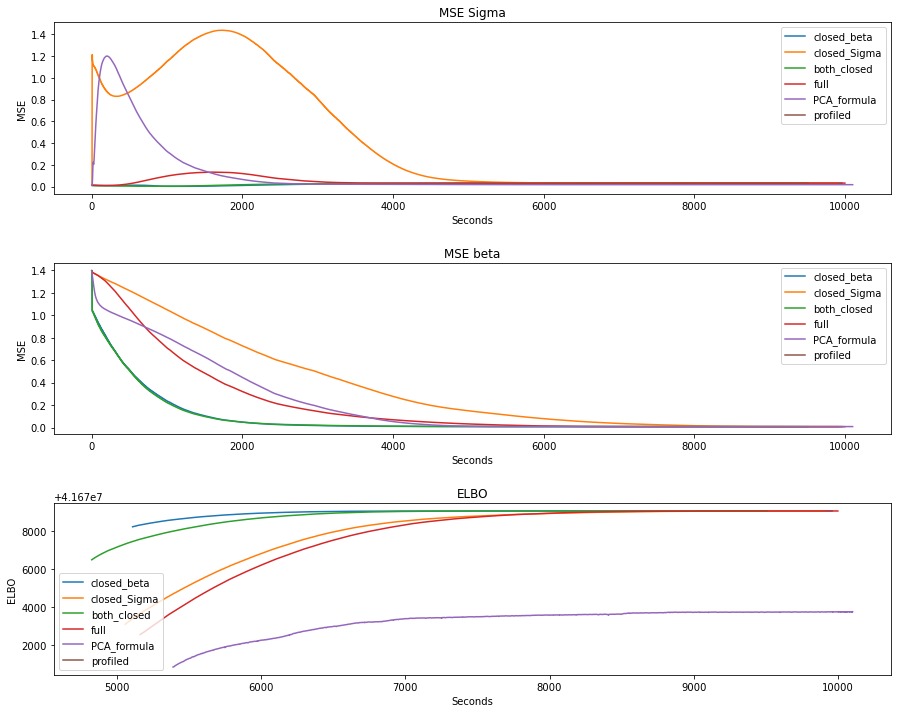

In [11]:
def compare_models(dict_models):
    '''
    function to compare models. It will plot the MSE of Sigma and beta according to the true parameters and 
    the ELBO in the y axis with the runtime in the x-axis.
    
    args : 
        'dict_models' dict with key the name of the model and values the model.
        
    returns : 
            None but displays the figure. you can save the figure if you uncomment the last line. 
    '''
    
    fig,ax = plt.subplots(3,1,figsize = (15,12))
    
    n,p = dict_models['PCA_formula'].Y.shape
    scaler = dict_models['PCA_formula'].ELBO_list[-1]
    for name,model in dict_models.items() : 
        
        d = model.beta.shape[0]

        abscisse = model.running_times
        plt.subplots_adjust(hspace = 0.4)
        ax[0].plot(abscisse, model.MSE_Sigma_list, label = name)
        ax[0].legend()
        #ax[0].set_ybound( lower=0, upper=0.7)
        ax[0].set_title('MSE Sigma')
        ax[0].set_xlabel('Seconds')
        ax[0].set_ylabel('MSE')
        
        ax[1].plot(abscisse, model.MSE_beta_list, label = name)
        ax[1].legend()
        ax[1].set_title('MSE beta') 
        ax[1].set_xlabel('Seconds')
        ax[1].set_ylabel('MSE')
        length = len(abscisse)
        
        keep = 0.5 # to keep the best ones 
        ax[2].plot(abscisse[-int(length*keep):], model.ELBO_list[-int(length*keep):], label = name )
        ax[2].legend()
        ax[2].set_title('ELBO')
        ax[2].set_ylabel('ELBO')
        ax[2].set_xlabel('Seconds')
        
    plt.savefig('n = 3000, p = 275.jpeg')
    plt.show()
    
compare_models(dict_models)

    

# Parametrisation centered in $X\beta$ and variance $CC^{\top}$

### VEM were we use only the closed form for  $\beta$ 

In [10]:
model_VEM_beta = PLN_full(C_init, beta_init, M_init, S_init, requires_tridiag = False)
%time model_VEM_beta.VEM_beta_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01163
 MSE with beta :  1.29612
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  250014.7159500122
 MSE with Sigma :  0.63955
 MSE with beta :  1.29612
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.67232
 MSE with beta :  0.91601
ELBO :  24119301.41534
Delta :  359884.44272771105
---------------------------------Maximum number of iterations reached :  20 last delta =  209740.97836720198
 MSE with Sigma :  1.00556
 MSE with beta :  0.91601
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.01261
 MSE with beta :  0.83031
ELBO :  28506999.37364
Delta :  222703.64052131027
---------------------------------Maximum number of iterations reached :  20 last delta =  201254.24995592982
 MSE with Sigma :  1.07328
 MSE with beta :  0.83031
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.07438
 MSE 

KeyboardInterrupt: 

### Gradient descent on all the parameters

In [17]:
model = PLN_full(C_init, beta_init, M_init, S_init)
%time model.full_grad_ascent(data, N_epoch = 20000,verbose=True, lr = 0.003)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01046
 MSE with beta :  1.29332
ELBO :  -309838272.86632
Delta :  -309838271.86632276
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  0.00773
 MSE with beta :  1.27074
ELBO :  32933394.18762
Delta :  62388.91227066517


KeyboardInterrupt: 

# Parametrisation centered in $X\beta$ and variance $\Sigma$

### VEM were we use only the closed form for  $\Sigma$ 

In [13]:
model_VEM_Sigma = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM_Sigma.VEM_Sigma_closed(data,Number_VEM_step =1000,verbose=True, lr = 0.001)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01056
 MSE with beta :  1.29518
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  1544552.9421429634
 MSE with Sigma :  0.01056
 MSE with beta :  1.27784
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.04423
 MSE with beta :  1.27703
ELBO :  inf
Delta :  inf
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  1.04423
 MSE with beta :  1.26793
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.9557
 MSE with beta :  1.26759
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.9557
 MSE with beta :  1.26355
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.93862
 MSE with beta :  1.26335
ELBO :  inf
Delta :  nan
---------------------------------Maxi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.64993
 MSE with beta :  1.18002
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.64993
 MSE with beta :  1.17766
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.64661
 MSE with beta :  1.17753
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.64661
 MSE with beta :  1.1752
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.6437
 MSE with beta :  1.17507
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.6437
 MSE with beta :  1.17275
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.64116
 MSE with beta :  1.17262
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last d

KeyboardInterrupt: 

### VEM were we use the closed form for  $\beta$ and $\Sigma$. Trully a VEM algorithm. 

In [15]:
model_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_VEM.VEM_both_closed(data,Number_VEM_step =1000, N_epoch_max = 20,verbose=True, lr = 0.001)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01056
 MSE with beta :  1.29612
ELBO :  -309838272.86632
Delta :  -309838271.86632276
---------------------------------Maximum number of iterations reached :  20 last delta =  556072.9780110121
 MSE with Sigma :  0.01056
 MSE with beta :  1.29612
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00694
 MSE with beta :  0.98693
ELBO :  inf
Delta :  inf
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00694
 MSE with beta :  0.98693
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.97581
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00693
 MSE with beta :  0.97581
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00693
 MSE with beta :  0.9631
ELBO :  inf
Delta :  nan
---------------------------------Maxi

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00594
 MSE with beta :  0.66421
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00594
 MSE with beta :  0.66421
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00586
 MSE with beta :  0.65526
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00586
 MSE with beta :  0.65526
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00577
 MSE with beta :  0.64639
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 last delta =  nan
 MSE with Sigma :  0.00577
 MSE with beta :  0.64639
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00568
 MSE with beta :  0.63761
ELBO :  inf
Delta :  nan
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  18696.003634005785
 MSE with Sigma :  0.00323
 MSE with beta :  0.44699
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00315
 MSE with beta :  0.44053
ELBO :  44997750.06953
Delta :  19120.947120293975
---------------------------------Maximum number of iterations reached :  20 last delta =  18630.96736807376
 MSE with Sigma :  0.00315
 MSE with beta :  0.44053
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00306
 MSE with beta :  0.43415
ELBO :  45371793.23279
Delta :  19036.65187443793
---------------------------------Maximum number of iterations reached :  20 last delta =  18565.438255630434
 MSE with Sigma :  0.00306
 MSE with beta :  0.43415
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00298
 MSE with beta :  0.42786
ELBO :  45744491.15901
Delta :  18952.84745812416
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  16812.945386603475
 MSE with Sigma :  0.00181
 MSE with beta :  0.30088
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0018
 MSE with beta :  0.2965
ELBO :  54607046.24067
Delta :  16957.565444521606
---------------------------------Maximum number of iterations reached :  20 last delta =  16739.256333760917
 MSE with Sigma :  0.0018
 MSE with beta :  0.2965
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00179
 MSE with beta :  0.29218
ELBO :  54942763.48287
Delta :  16879.287726454437
---------------------------------Maximum number of iterations reached :  20 last delta =  16665.332210056484
 MSE with Sigma :  0.00179
 MSE with beta :  0.29218
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00178
 MSE with beta :  0.28792
ELBO :  55276994.92861
Delta :  16800.98441810161
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  14749.65102866292
 MSE with Sigma :  0.00258
 MSE with beta :  0.20309
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00264
 MSE with beta :  0.2002
ELBO :  63138190.24551
Delta :  14818.402461342514
---------------------------------Maximum number of iterations reached :  20 last delta =  14670.704057224095
 MSE with Sigma :  0.00264
 MSE with beta :  0.2002
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00271
 MSE with beta :  0.19735
ELBO :  63432426.30486
Delta :  14737.83216111362
---------------------------------Maximum number of iterations reached :  20 last delta =  14591.611799173057
 MSE with Sigma :  0.00271
 MSE with beta :  0.19735
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00279
 MSE with beta :  0.19455
ELBO :  63725078.4157
Delta :  14657.16623878479
---------------------------------Maximum number of iterations reached :  20 last d

---------------------------------Maximum number of iterations reached :  20 last delta =  12580.332160681486
 MSE with Sigma :  0.00521
 MSE with beta :  0.13945
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00534
 MSE with beta :  0.1376
ELBO :  70520045.73092
Delta :  12618.041955932975
---------------------------------Maximum number of iterations reached :  20 last delta =  12499.098368763924
 MSE with Sigma :  0.00534
 MSE with beta :  0.1376
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00546
 MSE with beta :  0.13578
ELBO :  70770804.95524
Delta :  12536.024524986744
---------------------------------Maximum number of iterations reached :  20 last delta =  12417.851731032133
 MSE with Sigma :  0.00546
 MSE with beta :  0.13578
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00559
 MSE with beta :  0.13399
ELBO :  71019937.7236
Delta :  12454.012680023909
---------------------------------Maximum number of iterations reached :  20 las

---------------------------------Maximum number of iterations reached :  20 last delta =  10398.975561246276
 MSE with Sigma :  0.00891
 MSE with beta :  0.09908
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00906
 MSE with beta :  0.09792
ELBO :  76721160.25448
Delta :  10420.734905436635
---------------------------------Maximum number of iterations reached :  20 last delta =  10319.376454800367
 MSE with Sigma :  0.00906
 MSE with beta :  0.09792
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.0092
 MSE with beta :  0.09677
ELBO :  76928277.63143
Delta :  10340.709943264723
---------------------------------Maximum number of iterations reached :  20 last delta =  10239.917095348239
 MSE with Sigma :  0.0092
 MSE with beta :  0.09677
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00935
 MSE with beta :  0.09565
ELBO :  77133803.72569
Delta :  10260.833939790726
---------------------------------Maximum number of iterations reached :  20 la

---------------------------------Maximum number of iterations reached :  20 last delta =  8314.500074073672
 MSE with Sigma :  0.0128
 MSE with beta :  0.07364
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01294
 MSE with beta :  0.0729
ELBO :  81765087.68349
Delta :  8327.471263766289
---------------------------------Maximum number of iterations reached :  20 last delta =  8240.520554706454
 MSE with Sigma :  0.01294
 MSE with beta :  0.0729
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01308
 MSE with beta :  0.07218
ELBO :  81930561.12048
Delta :  8253.255014300346
---------------------------------Maximum number of iterations reached :  20 last delta =  8166.817537277937
 MSE with Sigma :  0.01308
 MSE with beta :  0.07218
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01322
 MSE with beta :  0.07146
ELBO :  82094557.61923
Delta :  8179.320344910026
---------------------------------Maximum number of iterations reached :  20 last delt

KeyboardInterrupt: 

# Parametrisation centered in $0$ and variance $I$


## Gradient descent with the PCA formula

In [16]:
model_PCA = PLN_full(C_init, beta_init, M_init, S_init)
%time model_PCA.full_grad_ascent_PCA(data, N_epoch = 15000,verbose=True, lr = 0.003)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01053
 MSE with beta :  1.29326
ELBO :  38207873.25626
Delta :  38207874.25626229
iteration number:  200
-------UPDATE-------
 MSE with Sigma :  1.07048
 MSE with beta :  0.98914
ELBO :  91431435.59078
Delta :  22092.50705073774
iteration number:  400
-------UPDATE-------
 MSE with Sigma :  1.25593
 MSE with beta :  0.93859
ELBO :  93188984.0805
Delta :  3723.9533174932003
iteration number:  600
-------UPDATE-------
 MSE with Sigma :  1.14124
 MSE with beta :  0.90828
ELBO :  93714261.17841
Delta :  1902.9233811944723


KeyboardInterrupt: 

# Parametrisation centered in 0 and variance Sigma

## VEM of the first notebook  

In [110]:
model_first_VEM = PLN_full(C_init, beta_init, M_init, S_init)
%time model_first_VEM.first_VEM(data,Number_VEM_step =1000, N_epoch_max = 20,verbose=True, lr = 0.01)

iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01683
 MSE with beta :  1.42789
ELBO :  672886.44394
Delta :  672887.4439430049
---------------------------------Maximum number of iterations reached :  20 last delta =  11896.76700986165
 MSE with Sigma :  0.01683
 MSE with beta :  1.25778
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00951
 MSE with beta :  1.25034
ELBO :  1050317.52274
Delta :  36659.96190730354
---------------------------------Maximum number of iterations reached :  20 last delta =  8044.187936921371
 MSE with Sigma :  0.00951
 MSE with beta :  1.13807
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.00909
 MSE with beta :  1.13359
ELBO :  1241185.8703
Delta :  11225.136133969761
---------------------------------Maximum number of iterations reached :  20 last delta =  6164.436613778584
 MSE with Sigma :  0.00909
 MSE with beta :  1.06656
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  0.01079
 MSE with beta : 

---------------------------------Maximum number of iterations reached :  20 last delta =  8.170653669163585
 MSE with Sigma :  1.33549
 MSE with beta :  0.78748
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.35009
 MSE with beta :  0.78716
ELBO :  1918961.88897
Delta :  18.356055904645473
---------------------------------Maximum number of iterations reached :  20 last delta =  7.078475828049704
 MSE with Sigma :  1.35009
 MSE with beta :  0.78112
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.3634
 MSE with beta :  0.78082
ELBO :  1919130.58844
Delta :  16.367620446253568
---------------------------------Maximum number of iterations reached :  20 last delta =  6.1965171347837895
 MSE with Sigma :  1.3634
 MSE with beta :  0.77508
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.37562
 MSE with beta :  0.77479
ELBO :  1919278.31598
Delta :  14.721906178398058
---------------------------------Maximum number of iterations reached :  20 last de

---------------------------------Maximum number of iterations reached :  20 last delta =  0.7625093006063253
 MSE with Sigma :  1.52543
 MSE with beta :  0.67446
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.52849
 MSE with beta :  0.67432
ELBO :  1920640.05221
Delta :  3.179100699722767
---------------------------------Maximum number of iterations reached :  20 last delta =  0.7278292661067098
 MSE with Sigma :  1.52849
 MSE with beta :  0.67172
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.53143
 MSE with beta :  0.67158
ELBO :  1920659.32022
Delta :  3.030372940003872
---------------------------------Maximum number of iterations reached :  20 last delta =  0.6978288462851197
 MSE with Sigma :  1.53143
 MSE with beta :  0.66902
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.53426
 MSE with beta :  0.66889
ELBO :  1920677.75897
Delta :  2.8915474952664226
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.3806735915131867
 MSE with Sigma :  1.58292
 MSE with beta :  0.60881
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58413
 MSE with beta :  0.60871
ELBO :  1921011.47566
Delta :  1.2840719004161656
---------------------------------Maximum number of iterations reached :  20 last delta =  0.37634967849589884
 MSE with Sigma :  1.58413
 MSE with beta :  0.60692
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.5853
 MSE with beta :  0.60683
ELBO :  1921020.75585
Delta :  1.2636519484221935
---------------------------------Maximum number of iterations reached :  20 last delta =  0.37155090109445155
 MSE with Sigma :  1.5853
 MSE with beta :  0.60506
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58643
 MSE with beta :  0.60496
ELBO :  1921029.92603
Delta :  1.243976149475202
---------------------------------Maximum number of iterations reached :  20 last

---------------------------------Maximum number of iterations reached :  20 last delta =  0.3003910242114216
 MSE with Sigma :  1.60429
 MSE with beta :  0.5621
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60462
 MSE with beta :  0.56202
ELBO :  1921239.9342
Delta :  0.9063316590618342
---------------------------------Maximum number of iterations reached :  20 last delta =  0.2971813522744924
 MSE with Sigma :  1.60462
 MSE with beta :  0.56064
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60492
 MSE with beta :  0.56056
ELBO :  1921247.07593
Delta :  0.8937568210531026
---------------------------------Maximum number of iterations reached :  20 last delta =  0.29459326388314366
 MSE with Sigma :  1.60492
 MSE with beta :  0.55919
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60519
 MSE with beta :  0.55911
ELBO :  1921254.1423
Delta :  0.8840063863899559
---------------------------------Maximum number of iterations reached :  20 last 

---------------------------------Maximum number of iterations reached :  20 last delta =  0.22332628699950874
 MSE with Sigma :  1.60456
 MSE with beta :  0.52616
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60428
 MSE with beta :  0.5261
ELBO :  1921407.31712
Delta :  0.6284733857028186
---------------------------------Maximum number of iterations reached :  20 last delta =  0.21362532046623528
 MSE with Sigma :  1.60428
 MSE with beta :  0.52494
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60397
 MSE with beta :  0.52487
ELBO :  1921412.42443
Delta :  0.5926260051783174
---------------------------------Maximum number of iterations reached :  20 last delta =  0.21741046058014035
 MSE with Sigma :  1.60397
 MSE with beta :  0.52371
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.60365
 MSE with beta :  0.52365
ELBO :  1921417.58829
Delta :  0.6068854329641908
---------------------------------Maximum number of iterations reached :  20 l

---------------------------------Maximum number of iterations reached :  20 last delta =  0.15547523368149996
 MSE with Sigma :  1.58983
 MSE with beta :  0.49401
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58896
 MSE with beta :  0.49395
ELBO :  1921525.15542
Delta :  0.4356669296976179
---------------------------------Maximum number of iterations reached :  20 last delta =  0.15545910014770925
 MSE with Sigma :  1.58896
 MSE with beta :  0.49284
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58806
 MSE with beta :  0.49278
ELBO :  1921528.77861
Delta :  0.43237787764519453
---------------------------------Maximum number of iterations reached :  20 last delta =  0.15118601243011653
 MSE with Sigma :  1.58806
 MSE with beta :  0.49167
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.58713
 MSE with beta :  0.49161
ELBO :  1921532.34948
Delta :  0.4248384772799909
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.11711207055486739
 MSE with Sigma :  1.55387
 MSE with beta :  0.46264
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.55195
 MSE with beta :  0.46258
ELBO :  1921609.78586
Delta :  0.33542190422303975
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11526696430519223
 MSE with Sigma :  1.55195
 MSE with beta :  0.46149
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.54998
 MSE with beta :  0.46143
ELBO :  1921612.46104
Delta :  0.3337338676210493
---------------------------------Maximum number of iterations reached :  20 last delta =  0.11115376721136272
 MSE with Sigma :  1.54998
 MSE with beta :  0.46034
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.54796
 MSE with beta :  0.46028
ELBO :  1921615.12449
Delta :  0.3272165155503899
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.08871011203154922
 MSE with Sigma :  1.48301
 MSE with beta :  0.43188
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.47956
 MSE with beta :  0.43182
ELBO :  1921673.8567
Delta :  0.26242438657209277
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08713338896632195
 MSE with Sigma :  1.47956
 MSE with beta :  0.43075
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.47605
 MSE with beta :  0.43069
ELBO :  1921675.92893
Delta :  0.2586842691525817
---------------------------------Maximum number of iterations reached :  20 last delta =  0.08755948557518423
 MSE with Sigma :  1.47605
 MSE with beta :  0.42962
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.47247
 MSE with beta :  0.42956
ELBO :  1921677.97871
Delta :  0.25666661467403173
---------------------------------Maximum number of iterations reached :  20

---------------------------------Maximum number of iterations reached :  20 last delta =  0.06895425007678568
 MSE with Sigma :  1.36632
 MSE with beta :  0.4014
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.36102
 MSE with beta :  0.40135
ELBO :  1921723.40643
Delta :  0.19757895357906818
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06107461708597839
 MSE with Sigma :  1.36102
 MSE with beta :  0.40027
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.35564
 MSE with beta :  0.40021
ELBO :  1921724.99653
Delta :  0.19185819057747722
---------------------------------Maximum number of iterations reached :  20 last delta =  0.06784511171281338
 MSE with Sigma :  1.35564
 MSE with beta :  0.39914
iteration number:  0
-------UPDATE-------
 MSE with Sigma :  1.3502
 MSE with beta :  0.39908
ELBO :  1921726.60332
Delta :  0.19471151544712484


KeyboardInterrupt: 

Here we have a PLN model described as the following : 

- Consider $n$ sites $(i=1 \ldots n)$

- Measure $x_{i}=\left(x_{i h}\right)_{1 \leq h \leq d}$ :
$x_{i h}=$ given environmental descriptor (covariate) for site $i$
(altitude, temperature, latitude, ...)

- Consider $p$ species $(j=1 \ldots p)$ Measure $Y=\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ :

- Measure $Y = Y_{i j}=$ number of observed individuals from species $j$ in site $i$ (abundance). 

- Associate a random vector $Z_{i}$ with each site Assume that the unknown $\left(Z_{i}\right)_{1 \leq i \leq n}$ are independant such that:
$$
Z_{i} \sim \mathcal{N}_{p}(x_i \beta, \Sigma) \quad \Sigma = CC^{\top}
$$

and $C$ is a lower triangular matrix. 
- Assume that the observed abundances $\left(Y_{i j}\right)_{1 \leq i \leq n, 1 \leq j \leq p}$ are independent conditionally on the $Z=\left(Z_{i}\right)_{i}$


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+Z_{i j}\right)\right)
$$

Where $O = (o_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ are known offsets. 

The unknown parameter is $\theta = (C,\beta)$.

$Z$ being a latent variable, we want to use the EM algorithm to derive the maximum likelihood estimator. However, it requires to compute 

$$
\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y\right)\right]=\mathbb{E}_{\theta}\left[p_{\theta}\left(Z_{i} \mid Y_{i}\right)\right] \propto \int_{\mathbb{R}^{p}} p_{\theta}\left(Z_{i}\right) \prod_{j} p_{\theta}\left(Y_{i j} \mid Z_{i j}\right) \mathrm{d} Z_{i}
$$ which is intractable in practice. 

We thus choose the variationnal approximation. We set

$$ 
q^{\star} = \underset{q \in \mathcal{Q_{gauss}}}{\operatorname{argmax}} J_{\theta,q}(Y) 
$$
<br>
$$
\begin{align} J_{\theta, q}(Y)& =\log p_{\theta}(Y)-K L\left[q(Z) \| p_{\theta}(Z \mid Y)\right]                                    \\ 
                              & = \mathbb{E}_{q}\left[\log p_{\theta}(Y, Z)\right] \underbrace{-\mathbb{E}_{q}[\log q(Z)]}_{\text {entropy } \mathcal{H}(q)}    \end{align}
$$

where 

$$
\mathcal{Q}_{\text {Gauss }}=\{
q=\left(q_{1}, \ldots q_{n}\right), q_{i} \sim \mathcal{N}\left(M_{i}, \operatorname{diag} (S_{i}\odot S_i ), M_i \in \mathbb{S} ^p, S_i \in \mathbb{R} ^p\right)\}
$$


The Variational EM (VEM) consists in alternate between two steps : 
- VE step: update $q$
$$
q^{h+1}=\underset{q \in \mathcal{Q_{gauss}}}{\arg \max } J_{\theta^{h}, q}(Y)=\underset{q \in \mathcal{Q_{gauss}}}{\arg \min } K L\left[q(Z) \| p_{\theta^{h}}(Z \mid Y)\right]
$$
- M step: update $\theta$
$$
\theta^{h+1}=\underset{\theta}{\arg \max } J_{\theta, q^{h+1}}(Y)=\underset{\theta}{\arg \max } \mathbb{E}_{q^{h+1}}\left[\log p_{\theta}(Y, Z)\right]
$$

Let's compute the ELBO $J_{\theta, q}(Y)$


$$
J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_{i}\right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i j}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+Z_{i j}\right)-\exp \left(o_{i j}+Z_{i j}\right)\right] + cst
\end{align}
$$

We need to compute some moments of $Z$ under $q$. 

$$
\mathbb{E}_{q}\left[Z_{i j}\right]=M_{i j} \quad \quad E_{q}\left[\operatorname{exp}\left(Z_{i j}\right)\right]=\frac{1}{2} \operatorname{exp}\left(M_{i j}+\frac{(S_{ij})^2}{2}\right)
$$

So that 

$$
\begin{aligned}
(1) &=\sum_{i, j} Y_{i j}\left(o_{i j}+M_{i j}\right)-\frac{1}{2} \exp \left(o_{i j}+M_{i j}+\frac{(S_{i_{jj}})^2}{2}\right) + cst \\
&=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S \odot S}{2}\right)\right)\mathbb{1}_p + cst 
\end{aligned}
$$



Where we have denoted $M = (M_{ij})_{1\leq i\leq n, 1\leq j\leq p}$ and $ S = (S_{ij})_{1\leq i\leq n, 1\leq j\leq p}$. The exponential is applied pointwise on the last equation. 

$$
\begin{aligned}
(3)=H(q) &=\sum_{i} H\left(q_{i}\right) \\
&=\sum_{i} \log \left(\sqrt{(2 \pi e)^{p}\left|S_{i}\right|}\right) \\
&=\frac 12\sum_{i} \log (S_{i} \odot S_i)^2 +cst \\
&= \frac 12 \sum_{i j} \log S_{i j}^2+cst \\
& = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst\\
\end{aligned}
$$

Where the log is applied pointwise at the last equation. 

$$
\begin{aligned}
(2)=\mathbb{E}_{q}\left[\log p_{\theta}(Z)\right] &=\sum_{1} E_{q}\left[\log p_{\theta}\left(Z_{i}\right)\right] \\
&=-\frac{n}{2} \log |\Sigma|+\sum_{i} \mathbb{E}_{q}\left[-\frac{1}{2}\left(Z_{i}-X_{i} \beta\right)^{\top} \Sigma^{-1}\left(Z_{i} - X_{i} \beta\right)\right] +cst
\end{aligned}
$$

$
\text { Let } V \sim \mathcal{N} \left(\mu, \Lambda), \mu \in \mathbb{R}^{p}, \Lambda \in \mathcal S _p ^{++}\right.  \\
\text { Let's compute } \; \mathbb{E}\left[V^{\top} \Sigma^{-1} V\right]
$

We denote $\Sigma ^{-1 / 2}$ the square root Matrix of $\Sigma^{-1}$. It exists since $\Sigma ^{-1} \in \mathcal{S}_p^{++}$. 

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\left[V^{\top}\Sigma ^{-1 / 2} \Sigma^{-1 / 2} V\right]\\
&=\mathbb{E}\left[\left(\Sigma^{-1 / 2} V\right)^{\top}\left(\Sigma^{-1 / 2} V\right)\right] \\
&=\mathbb{E} \|\Sigma^{-1 / 2} V \|_{2}^{2}
\end{aligned}
$$

$
\text {Let } \tilde{V}=\Sigma^{-1 / 2} V, \quad \tilde{V} \sim \mathcal{N}\left(\Sigma^{-1 / 2} \mu,  \Sigma^{-1 / 2} \Lambda \Sigma^{-\frac{1}{2}}\right)
$

$$
\begin{aligned}
\mathbb{E}\left[V^{\top} \Sigma^{-1} V\right] &=\mathbb{E}\|\widetilde{V}\|_{2}^{2} \\
&=\sum \mathbb E \widetilde{V}_{j}^{2} \\
&=\sum \operatorname{var}\left(\widetilde{V}_{j}\right)^{2}+\mathbb{E}\left[\widetilde{V}_{j}\right]^{2}\\
&=\sum_{j}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)_{j j}+\left(\Sigma^{-1 / 2} \mu\right)^{2}_j\\
&= \operatorname{tr}\left(\Sigma^{-1 / 2} \Lambda \Sigma^{-1 / 2}\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1 / 2}\right)^{\top} \mu\right)^{2}\\
&=\operatorname{tr}\left(\Sigma^{-1} \Lambda\right)+\sum_{j}\left(\left(\Sigma_{j,.}^{-1/2}\right)^{\top} \mu\right)^2
\end{aligned}
$$

Since under $q$, $Z_{i}-X_{i} \beta \sim \mathcal N (M_i - X_i \beta, S_i \odot S_i ) $
$$
\begin{equation}
\begin{aligned}
(2) &=- \frac 12 \sum_{i} \operatorname{tr}\left(\Sigma^{-1} (S_{i} \odot S_i) \right) - \frac 12 \sum_{i, j}\left(\left(\Sigma_{j,.}^{-1 / 2} \right) ^{\top}\left(M_{i}-X_{i} \beta\right)\right)^2  - \frac n2 \log |\Sigma|+ cst  \\
&= - \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i}\odot S_i \right)\right) - \frac 12 \sum_{i, j}\left(\Sigma^{-1 / 2}(M-X \beta)\right)_{j, i}^{\top}\left(\Sigma
^{-1 / 2}(M-X \beta)\right)_{i, j}  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\sum_{i} S_{i} \odot S_i  \right)\right)- \frac 12 \operatorname{tr}\left(\Sigma^{-1 / 2}(M-X \beta)^{\top}(M-X \beta) \Sigma^{-1 / 2}\right)  - \frac n2 \log |\Sigma|+ cst  \\
&=- \frac 12 \operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right)  - \frac n2 \log |\Sigma|+ cst 
\end{aligned}
\end{equation}
$$
We then have : 

PARAMETRISATION CENTERED IN $X\beta$ and variance $\Sigma$


$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left(\Sigma^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - \frac n2 \log |\Sigma|+ cst 
\end{align}}$$



If we use $C$ instead of $\Sigma$ : 


PARAMETRISATION CENTERED IN $X\beta$ and variance $CC^{\top}$

$$\boxed{\begin{align} J_{\theta, q}(Y) &=\mathbb{1}_n^{\top}\left(Y \odot(O+M)-\frac{1}{2} \exp \left(O+M+\frac{S\odot S}{2}\right) + \frac 12 \log (S \odot S) \right)\mathbb{1}_p \\
& \quad  - \frac 12\operatorname{tr}\left((CC^{\top})^{-1}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+(M-X \beta)^{\top}(M-X \beta)\right)\right) \\
& \quad  - n \log |C|+ cst 
\end{align}}$$

We consider the same setting but another parametrization of the model : 

$$
\begin{array}{l}
Z_{i} \sim \mathcal N_{p}\left(0, I_{p}\right) \\
Y_{i j} \mid Z_{i} \sim \mathcal P \left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right)
\end{array}
$$
Writing in Matrix form : 

$$
Y \mid Z \sim \mathcal P\left(\exp \left(O+X \beta+ ZC\right)\right)
$$

This parametrization asks less things to the Variational part. 

Let's compute the ELBO $\tilde J_{\theta, q}(Y)$ of this new parametrisation. 


$$
\tilde J_{\sigma, q}(Y)=\underbrace{\mathbb{E}_{q}\left[\log p_{\theta}(Y \mid Z)\right]}_{(1)}+\underbrace{E_{q}\left[\log p_{\theta}(Z)\right]}_{(2)}+\underbrace{H(q)}_{(3)}
$$
$$
\begin{align}
(1)& =\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z\right)\right] \\
&=\sum_{i} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i} \mid Z_i \right)\right] \\
&=\sum_{i, j} \mathbb{E}_{q}\left[\log p_{\theta}\left(Y_{i j} \mid Z_{i}\right)\right] \\
& =\sum_{i, j} \mathbb{E}_{q}\left[Y_{i j}\left(o_{i j}+x_{i}^{\top} \beta_{j}+ C_{j}^{\top} Z_i\right)-\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+C_{j}^{\top} Z_i\right)\right] + cst
\end{align}
$$

Let $1\leq i \leq n, 1 \leq j \leq p$. Let's compute $\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right]$


$$
\begin{aligned}
\mathbb{E}_{q}\left[\exp \left(C_{j}^{\top} Z_{i}\right)\right] &=\mathbb{E}_{q}\left[\exp \left(\sum_{k=1}^{p} C_{j k}Z_{ik}\right)\right] \\
&=\mathbb{E}_{q}\left[\prod_{k=1}^{p} \exp \left(C_{j k} Z_{i k}\right)\right] \\
&=\prod_{k=1}^p\mathbb{E}_{q} \left[\exp \left(C_{j k} Z_{i k}\right)\right] \\ 
&=\prod_{k=1}^{p} exp \left(M_{i_{k}} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&= \exp \left(\sum_{k=1}^{p} M_{i k} C_{j k}+\frac{C_{j k}^{2} S_{i k}^{2}}{2}\right) \\
&=\exp \left(M_{i}^{\top} C_{j}+\frac{\left(S_{i}^{2}\right)^{T} C_{j}^2}{2}\right)
\end{aligned}
$$

Ainsi, 

$$
(1)=1_{n}^{\top}\left(Y \odot (O+X \beta+MC) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{  (S \odot S)(C\odot C) }{2}\right)\right)1_{p}
$$

For $(2)$, we take $X\beta = 0, \Sigma = I_p$ in $(2)$ from the previous parametrisation to get : 
$$
(2) = - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right)  - \frac {n}2 \log 1 + cst 
$$

For $(3)$, we have a similar argument as in $(3)$ from previous parametrisation to get : 

$$(3) = \frac 12 \mathbb{1}_n ^{\top}(\log S\odot S  )\mathbb{1}_p+cst$$

We then get : 

PARAMETRISATION CENTERED IN 0 AND UNIT VARIANCE 

$$ 
\boxed{\begin{align}\tilde J_{\sigma, q}(Y) & = 1_{n}^{\top}\left(Y \odot (O+X \beta+C M) - \left(\frac{1}{2}\right)^{p} \operatorname{exp}\left(O+X\beta+C M+\frac{(C\odot C)   (S \odot S)}{2}\right)+ \frac 12 
\log S\odot S \right)1_{p} \\
                                            &  - \frac 12 \operatorname{tr}\left(\operatorname{diag}(\mathbb{1}_n^{\top} (S\odot S))+M^{\top}M\right) \\ 
                    \end{align} }
$$

We can have a last parametrization that is : 

$$
Z_{i} \sim \mathcal{N}_{p}(0, \Sigma)
$$

and 


$$
\left(Y_{i j} \mid Z_{i j}\right) \sim \mathcal{P}\left(\exp \left(o_{i j}+x_{i}^{\top} \beta_{j}+Z_{i j}\right)\right)
$$

This model is equivalent to the other ones but the variational step is different. 

PARAMETRISATION CENTERED IN 0 AND VARIANCE $\Sigma$

$$
\boxed{
\begin{aligned}
J_{\theta, q}(y) &=-\frac{n}{2} \log |\Sigma|-\frac{1}{2} \sum_{i} m_{i}^{\top} \Sigma^{-1} m_{i}+tr\left(\Sigma^{-1} S_{i}\right) \\
&+\sum_{i, j}-\exp \left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}+\left[S_{i}\right]_{j j}^{2} / 2\right)+Y_{i j}\left(o_{i j}+x_{i}^{T} \beta_{j}+m_{i j}\right) \\
&+\frac{1}{2} \sum_{i} \log \left|(S\odot S)_{i}\right|+c s t .
\end{aligned}}
$$
    

In [170]:
def f(x) : 
    return x**2

x = torch.tensor([8.])
x.requires_grad_(True)
test_optim = torch.optim.SGD([x], lr = 2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(test_optim, factor = 0.5, patience = 1)

for i in range(100): 
    
    print('normalement : ',x-2*test_optim.param_groups[0]['lr']*x)
    loss = f(x)
    loss.backward()
    test_optim.step()
    scheduler.step(loss.item())
    test_optim.zero_grad()
    print('lr : ', test_optim.param_groups[0]['lr'])
    print('x : ', x )

normalement :  tensor([-24.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([-24.], requires_grad=True)
normalement :  tensor([72.], grad_fn=<SubBackward0>)
lr :  2
x :  tensor([72.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([216.], grad_fn=<SubBackward0>)
lr :  1.0
x :  tensor([216.], requires_grad=True)
normalement :  tensor([-216.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([-216.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.5
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], requires_grad=True)
normalement :  tensor([0.], grad_fn=<SubBackward0>)
lr :  0.25
x :  tensor([0.], 